# <font color=#E67E22>**Measure fairness in healtcare-related database using the Aequitas toolkit**</font>

***Simone Callegarin*** - **932342** - **232592** - simone.callegarin@mail.polimi.it

Link to the [**github repository of the project**](https://github.com/SimoneCallegarin/TIS_project).

## <font color=#E5986>**Steps**</font>

The notebook is divided into six parts as it follows:
>*   <font color=#FFE999>Setting up the Developement Environment</font>
*   <font color=#93C47D>Audit Configuration</font>
*   <font color=#76B5AF>Dataset</font>
  *   <font color=#86AA9F>Data Description</font>
  *   <font color=#86AA9F>Data Analysis</font>
*   <font color=#6D9EDB>Predictive Algorithm</font>
  *   <font color=#6F95BB>Checking for Null Values or Missing Values</font>
  *   <font color=#6F95BB>Random Forest Classifier</font>
*   <font color=#C27BA0>Data Preprocessing</font> <font color=#AF8FA9>(+ Upload)</font>
*   <font color=#8E7CC3>Predicted Data Exploration</font>
*   <font color=#E00050>Auditing Fairness of the Model using Aequitas</font>
  *   <font color=#BE2F00>Dataframe</font>
  *   <font color=#BE2F00>Sensitive Attribute</font>
*   <font color=#EF9A7D>Bibliography</font>

## <font color=#FFE999>Setting up the Developement Environment</font>
Packages installation and modules import

In [98]:
%%capture
!pip install aequitas
# Import Aequitas preprocessing tool for the dataframe
from aequitas.preprocessing import preprocess_input_df
# Import Aequitas Group
from aequitas.group import Group
# Import Aequitas Bias 
from aequitas.bias import Bias
# Import Aequitas Fairness
from aequitas.fairness import Fairness
# Import Aequitas Plot
import aequitas.plot as ap
# Import Aequitas Plotting
from aequitas.plotting import Plot
# storing Plot class
aqp = Plot()

# Import Pandas, a data analysis and manipulation tool
import pandas as pd
# Import Numpy, a package for scientific computing in Python
import numpy as np
# Import Seaborn, a data visualization library based on matplotlib
import seaborn as sns

# Import the Random Forest Classifier, a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset
from sklearn.ensemble import RandomForestClassifier
# Import train_test_split, to split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split
# Import the metrics to evaluate the classifier
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score

# Update Pillow for graphs and images
!pip install Pillow==9.0.0
# Import PyPlot, a state-based interface to matplotlib that provides an implicit, MATLAB-like, way of plotting.
import matplotlib.pyplot as plt
# Import PlotLy to do other graph plotting
import plotly.graph_objects as go

# Import the requests module to send a PUT request
import requests
# Import the base64 module for encoding a file to base64
import base64

# Import Jupyter widgets pack (for the dropdown menu)
import ipywidgets as widgets
# Import the public API for display tools in IPython
from IPython.display import display

# Import the module to load files locally
from google.colab import files
# Import tools for working with streams
import io
# Import package to work with JSON data
import json

# Import warnings to ignore pandas 1.5.0 incopatibility problems
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Fixed some warnings
pd.options.mode.chained_assignment = None

# Added a color palette for the graphs
aq_palette = sns.diverging_palette(225, 35, n=2)
%matplotlib inline

This is a PyPi package that I released containing all the functions to print formatted dataframes in <font color=lightblue>light blue</font> and <font color=gray>gray</font> shaded tables in order to facilitate the analysis of the dataframe: 
[here's the repository of the package](https://github.com/SimoneCallegarin/DataframeFormatting)

In [2]:
!pip install SCdataframeFormatter
from SCdataframeFormatter import dfFormatter as dff

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# <font color=#93C47D>Audit Configuration</font>
Select the dataset, the sensitive attribute and whether to upload the processed Data
   

Select the link to the dataset that has to be analyzed.

Our dataset is made available through the [repository](https://github.com/SimoneCallegarin/TIS_project/blob/main/raw_data/diabetes.csv):

In [3]:
dataset_link = "https://raw.githubusercontent.com/SimoneCallegarin/TIS_project/master/raw_data/diabetes.csv"

Store the dataset in a pandas dataframe:

In [4]:
df = pd.read_csv(dataset_link)

Drop the first column that isn't relevant for further analysis (the *entity_id*s), in order to keep only relevant columns:

In [5]:
df = df.drop(df.columns[[0]], axis=1) 

Select the sensitive attribute to search for discriminations from a dropdown menu:

In [6]:
sensitive_attribute = df.columns[-1]

dropdown_menu = widgets.Dropdown(
    options=df.columns,
    value=df.columns[-1],
    description='Sensitive attribute:',
)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        sensitive_attribute = change['new']
        print("selected sensitive attribute %s" % sensitive_attribute)

dropdown_menu.observe(on_change)

display(dropdown_menu)

Dropdown(description='Sensitive attribute:', index=9, options=('Pregnancies', 'Glucose', 'BloodPressure', 'Ski…

Retrive the GitHub token that must be saved in a *json* file under the key *data_api_key* and that will permit to push data directly into the github repository:

In [7]:
user_input = input('Do you need to upload the data?: ')

yes_choices = ['yes', 'y', 'ok']

if user_input.lower() in yes_choices:

    data_upload = True

    # Use files.upload to produce the "Choose Files" button below, then select your file.
    uploaded = files.upload()

    # Use io.BytesIO to decode the file, then json.load to open it.
    file = io.BytesIO(uploaded['APIkey.json'])

    # API token of the github repository
    githubToken = json.load(file)['data_api_key']
else:
    data_upload = False
    print('No need to upload data')

Do you need to upload the data?: y


Saving APIkey.json to APIkey.json


# <font color=#76B5AF>Dataset</font>
The original Diabetes Dataset has been taken from [Diabetes 130-Hospitals](https://www.openml.org/search?type=data&status=active&id=43903)

This dataset represents 10 years of clinical care at 130 U.S. hospitals and delivery networks, collected from 1999 to 2008. 
Each record represents the hospital admission record for a patient diagnosed with diabetes whose stay lasted between one to fourteen days. 
The features describing each encounter include demographics, diagnoses, diabetic medications, number of visits in the year preceding the encounter, and payer information, as well as whether the patient was readmitted after release, and whether the readmission occurred within 30 days of the release.

The original "Diabetes 130-Hospitals" dataset was collected by Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore in 2014.

---

It was provided an already preprocessed version of the original one that can be found [here](https://www.kaggle.com/datasets/mathchi/diabetes-data-set).

All patients here are females at least 21 years old of Pima Indian heritage.

Here is the meaning of what the values of each column are referring:

* Pregnancies: Number of times pregnant
* Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressure: Diastolic blood pressure (mm Hg)
* SkinThickness: Triceps skin fold thickness (mm)
* Insulin: 2-Hour serum insulin (mu U/ml)
* BMI: Body mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction: Diabetes pedigree function
* Age: Age (years)
* Outcome: Class variable (1 if diabetic, 0 otherwise)


Here the dataset can be filtered, sorted, and explored dynamically:

In [10]:
# extension that renders pandas dataframes into interactive tables that can be filtered, sorted, and explored dynamically
%load_ext google.colab.data_table 
df

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6.0      148           72.0           35.0     30.5  33.6   
1            1.0       85           66.0           29.0     30.5  26.6   
2            8.0      183           64.0           23.0     30.5  23.3   
3            1.0       89           66.0           23.0     94.0  28.1   
4            0.0      137           40.0           35.0    168.0  43.1   
..           ...      ...            ...            ...      ...   ...   
758         10.0      101           76.0           23.0    180.0  32.9   
759          2.0      122           70.0           27.0     30.5  36.8   
760          5.0      121           72.0           23.0    112.0  26.2   
761          1.0      126           60.0           23.0     30.5  30.1   
762          1.0       93           70.0           31.0     30.5  30.4   

     DiabetesPedigreeFunction   Age  Outcome  AgeCategory  
0                       0.627  50.0        1            1  
1                       0.351  31.0        0            1  
2                       0.672  32.0        1            1  
3                       0.167  21.0        0            0  
4                       0.374  33.0        1            1  
..                        ...   ...      ...          ...  
758                     0.171  63.0        0            1  
759                     0.340  27.0        0            1  
760                     0.245  30.0        0            1  
761                     0.349  47.0        1            1  
762                     0.315  23.0        0            0  

[763 rows x 10 columns]

## <font color=#86AA9F>Dataset Description</font>
A comprehensive description of the dataframe

Brief description of how the dataset is structured:

In [11]:
df.describe().T

count        mean        std     min      25%  \
Pregnancies               763.0    3.788991   3.275421   0.000   1.0000   
Glucose                   763.0  121.686763  30.535641  44.000  99.0000   
BloodPressure             763.0   72.226737  11.142938  38.000  64.0000   
SkinThickness             763.0   26.256881   7.482583  10.000  23.0000   
Insulin                   763.0   71.029161  59.760128  14.000  30.5000   
BMI                       763.0   32.194495   6.411094  18.200  27.5000   
DiabetesPedigreeFunction  763.0    0.408339   0.215128   0.078   0.2435   
Age                       763.0   32.787680  11.064569  21.000  24.0000   
Outcome                   763.0    0.348624   0.476847   0.000   0.0000   
AgeCategory               763.0    0.653997   0.476006   0.000   0.0000   

                              50%      75%      max  
Pregnancies                 3.000    6.000   13.000  
Glucose                   117.000  141.000  199.000  
BloodPressure              72.000   80.000  106.000  
SkinThickness              23.000   31.000   45.000  
Insulin                    31.250  105.000  272.000  
BMI                        32.000   36.300   50.000  
DiabetesPedigreeFunction    0.374    0.548    0.997  
Age                        29.000   40.000   66.000  
Outcome                     0.000    1.000    1.000  
AgeCategory                 1.000    1.000    1.000

The number of people that were diagnosed with diabetes is identified by the class variable *Outcome* with value 1, while non-diabetic people are labeled with 0:

In [12]:
print(df['Outcome'].value_counts())

0    497
1    266
Name: Outcome, dtype: int64


An histogram representing the difference in number between who is a diabetic patient and who is not:

In [13]:
labels = ['Non-Diabetes','Diabetes']
fig = go.Figure([go.Bar(x=labels, y=df['Outcome'].value_counts())])
fig.update_layout(autosize=False, width=600, height=600)
fig.show()

A pie chart representing the difference in number between who is a diabetic patient and who is not:

In [14]:
fig = go.Figure(data=[go.Pie(labels=labels, values=df['Outcome'].value_counts())])
fig.update_layout(autosize=False, width=600, height=400)
fig.show()

Histograms representing the distribution of each attribute:

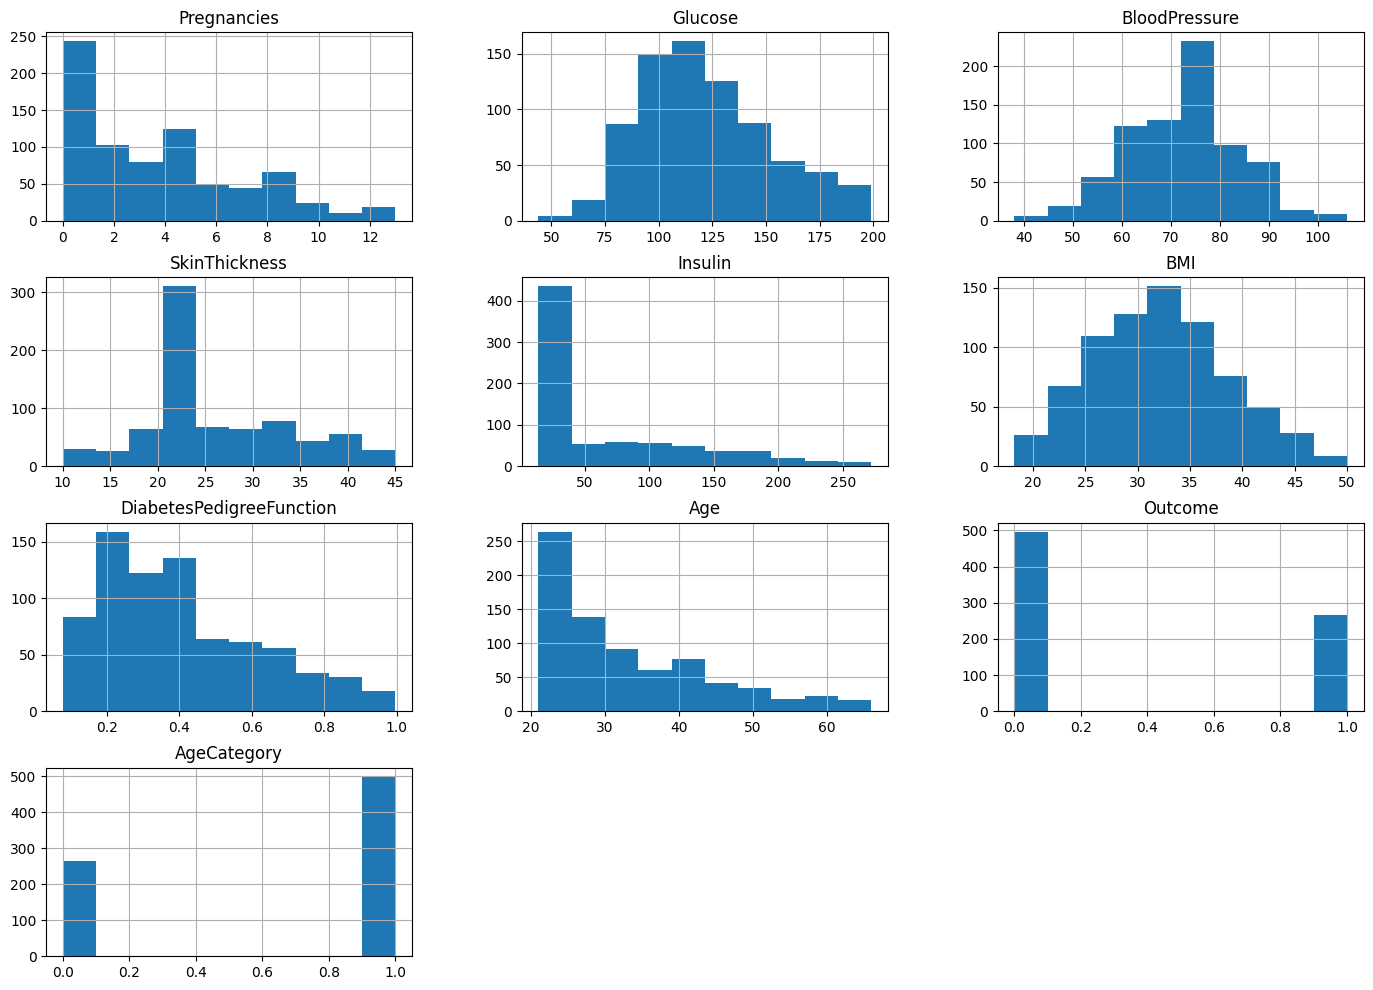

In [15]:
df.hist(figsize=(17,12))
plt.show()

## <font color=#86AA9F>Dataset Analysis</font>
A preliminary analysis of data correlation

An heatmap for correlation of parameters that permits to see how much different attributes are correlated between each other.

Values closer to 1 means higher correlation

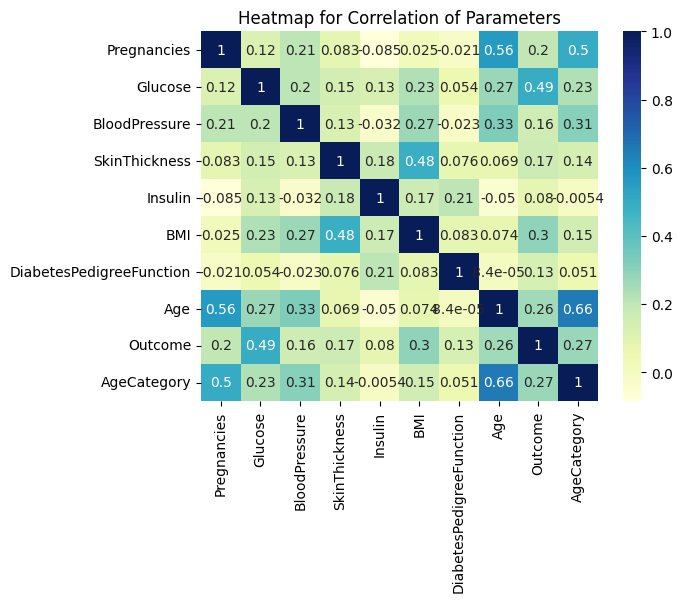

In [16]:
corr = df[df.columns].corr()
sns.heatmap(corr, cmap="YlGnBu", annot = True)
sns.set(rc={'figure.figsize':(10,10)})
plt.title('Heatmap for Correlation of Parameters')
plt.show()

From the heatmap we can see that there are few attributes which are having a mild correlation with the *Outcome*, for example *Glucose*, *BMI* and our sensitive attribute, the *AgeCategory*

This kind of correlation is easily discernible from a kernel density estimate (KDE) plot, that permits to compare the distribution of each attribute with the *Outcome*:

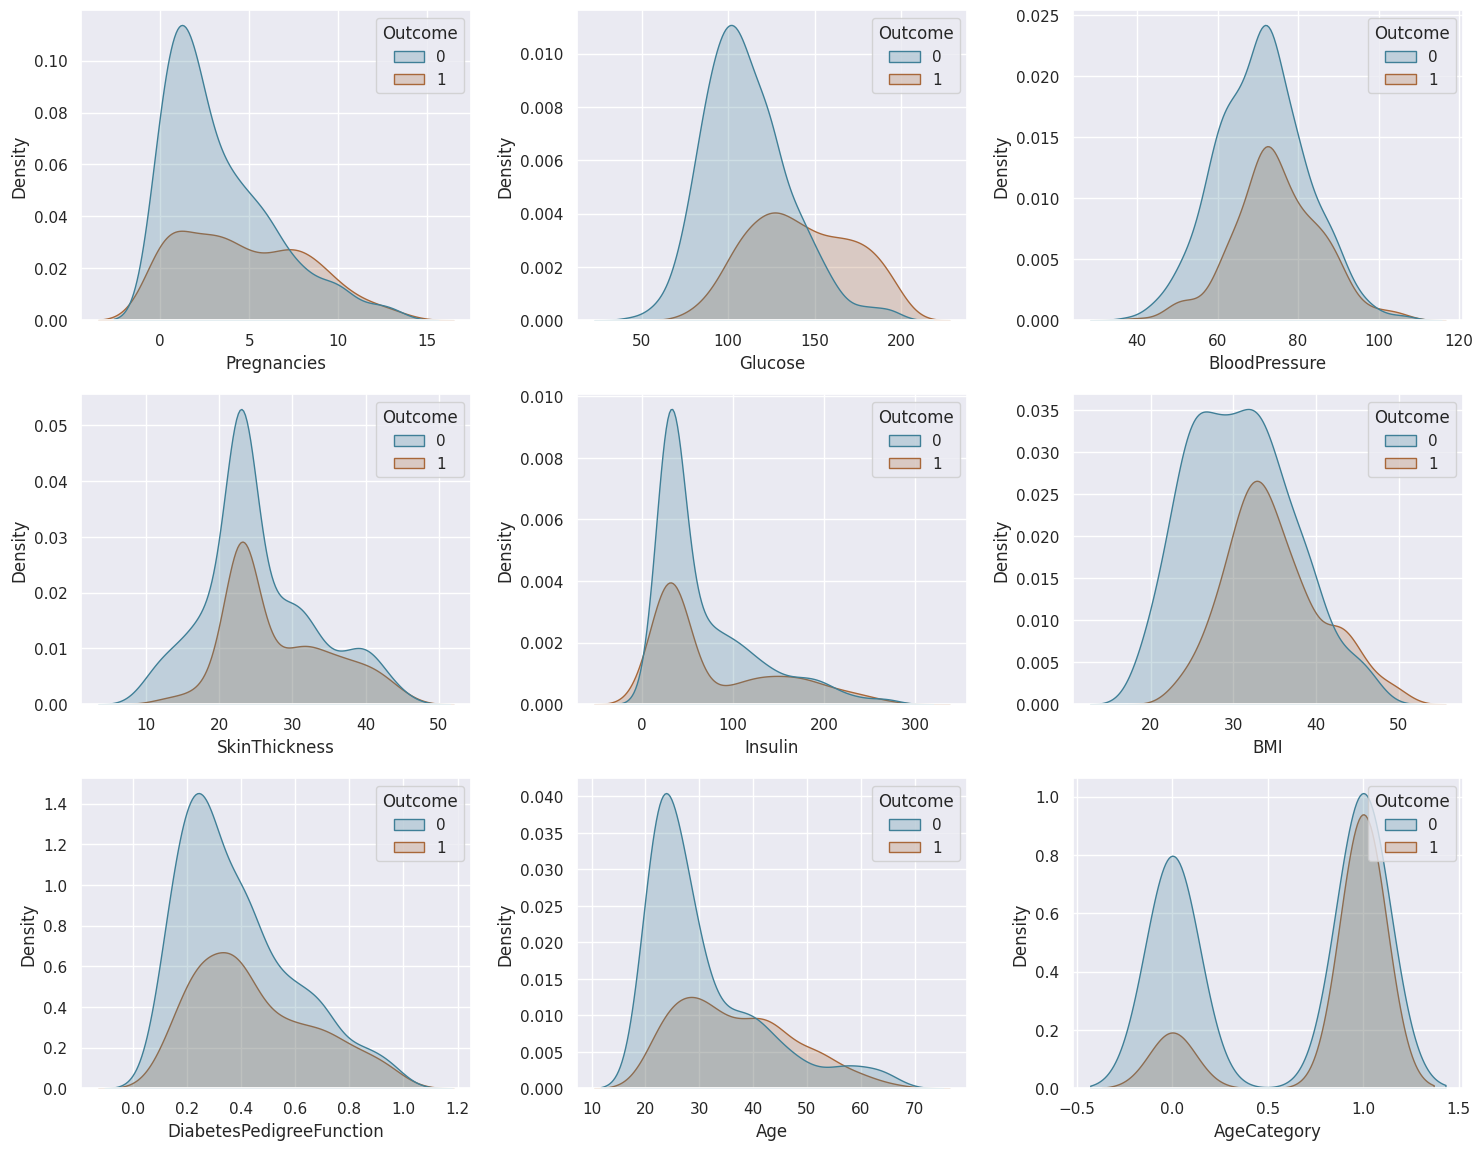

In [17]:
plt.figure(figsize=(15,15))
i=1
for col in df.columns:
  if col != "Outcome":
    plt.subplot(4,3,i)
    sns.kdeplot(data=df, x=col, hue="Outcome", fill=True, palette=aq_palette)
    i=i+1
plt.tight_layout()

Focusing on the *AgeCategory* distribution is very easy to notice how much the *Outcome* depend on that attribute:

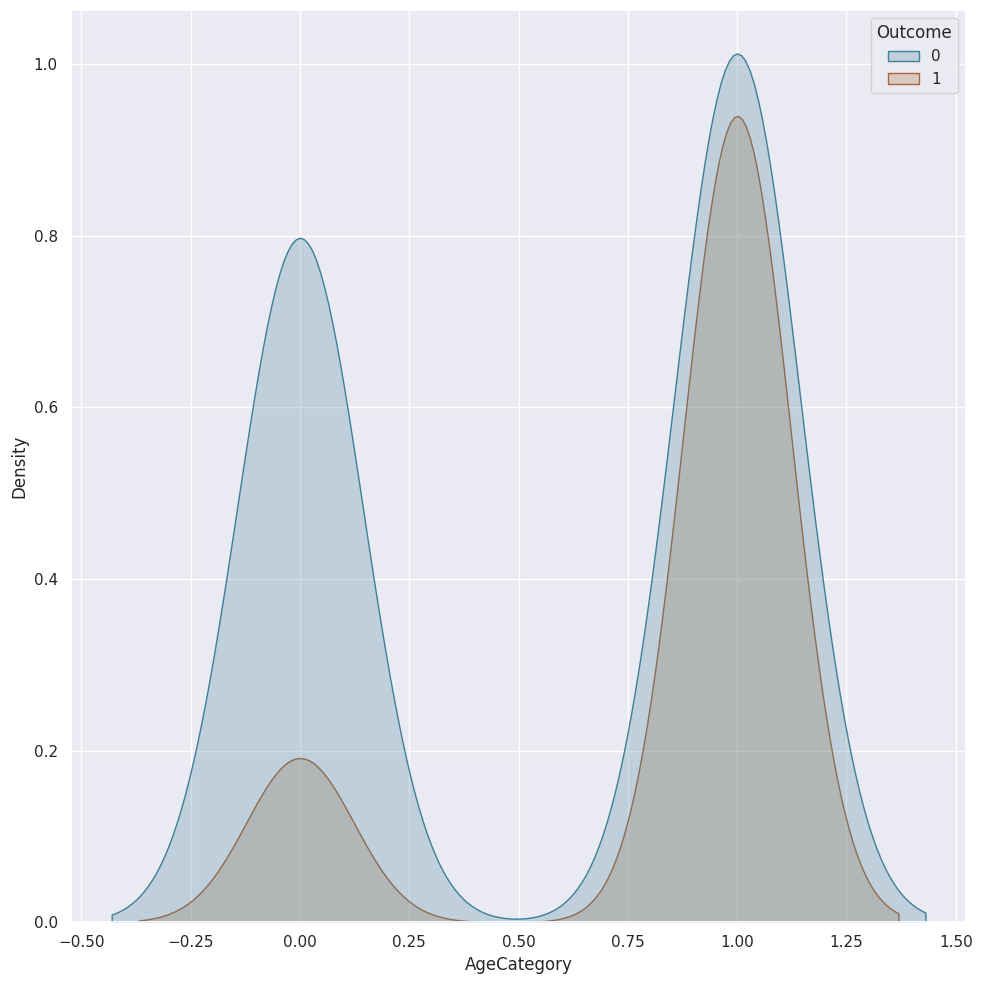

In [18]:
plt.figure(figsize=(10,10))
sns.kdeplot(data=df, x="AgeCategory", hue="Outcome", fill=True, palette=aq_palette)
plt.tight_layout()

This underlines a high dependence of positivity to diabetes with the age of the patient.


---


In the next sections of the notebook, we will examine whether the predictive model we used is affected by this dependence or not.

# <font color=#6D9EDB>Predictive Algorithm</font>
Use a predictive model to predict if an individual has diabetes based on his or her physical parameters

## <font color=#6F95BB>Checking for Null Values or Missing Values</font>
In order to apply a predictive algorithm correctly it's necessary to check whether the dataset contains or not *Null* or *Missing* values

In [19]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
AgeCategory                 0
dtype: int64

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 763 entries, 0 to 762
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               763 non-null    float64
 1   Glucose                   763 non-null    int64  
 2   BloodPressure             763 non-null    float64
 3   SkinThickness             763 non-null    float64
 4   Insulin                   763 non-null    float64
 5   BMI                       763 non-null    float64
 6   DiabetesPedigreeFunction  763 non-null    float64
 7   Age                       763 non-null    float64
 8   Outcome                   763 non-null    int64  
 9   AgeCategory               763 non-null    int64  
dtypes: float64(7), int64(3)
memory usage: 59.7 KB


The check is over, the analysis reported that there were no missing or null values.

## <font color=#6F95BB>Random Forest Classifier</font>
A **Random Forest** is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. 

Documentation can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

Define:

- **`x`** = the dataframe without the *Outcome* column
- **`y`** = the *Outcome* column

In [21]:
x = df.drop(['Outcome'],axis=1)
y = df.Outcome

Define the test and training sets:

The **test set** size is defined on the 20% of the dataframe, the rest (80%) is assigned to the **training set**

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.2)

The shape of each training and test set:

In [23]:
print("x_train ->",x_train.shape)
print("x_test ->",x_test.shape)
print("\ny_train ->",y_train.shape)
print("y_test ->",y_test.shape)

x_train -> (610, 9)
x_test -> (153, 9)

y_train -> (610,)
y_test -> (153,)


Run the Random Forest Classifier on the training set previously originated:

In [24]:
rf = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=0)

Predictions made by the Random Forest Classifier on the test set:

In [25]:
rf_prediction = rf.predict(x_test)

Define some **metrics** to evaluate the goodness of the model: 

In [26]:
a = accuracy_score(y_test,rf_prediction)
r = recall_score(y_test,rf_prediction)
p = precision_score(y_test,rf_prediction)
c = confusion_matrix(y_test,rf_prediction)

In [27]:
print('Accuracy', a*100)

Accuracy 78.43137254901961


In [29]:
print('Recall:', r*100)

Recall: 68.75


In [30]:
print('Precision:', p*100)

Precision: 64.70588235294117


In [28]:
print('Confusion Matrix:\n', c)

Confusion Matrix:
 [[87 18]
 [15 33]]


Graphical representation of the confusion matrix:

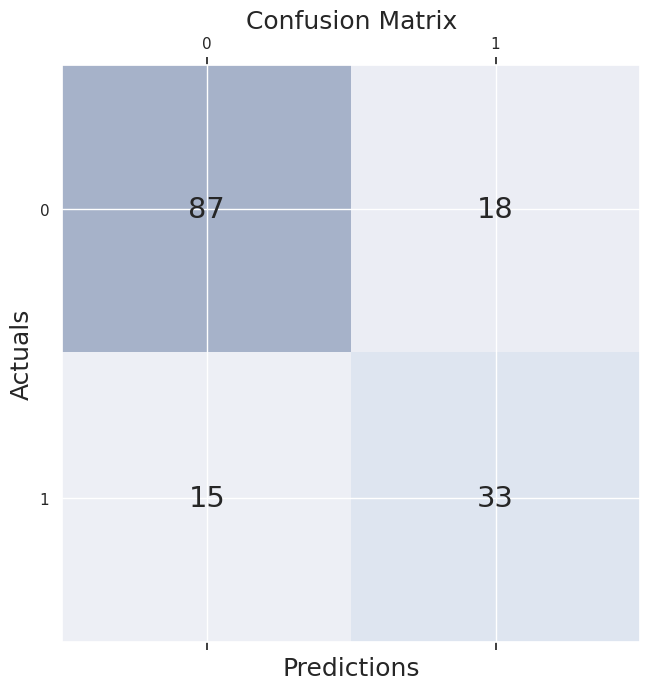

In [31]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(c, cmap=plt.cm.Blues, alpha=0.3)
for i in range(c.shape[0]):
    for j in range(c.shape[1]):
        ax.text(x=j, y=i,s=c[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In our analysis we are particularly interested in people who were predicted negative when they are actually diabetic, this value (15 in the confusion matrix) will lead us to select **FNR** as one of the interesting metrics as we will see after.

# <font color=#C27BA0>Data Preprocessing</font>
The next step is to pre-process the Data provided in order to assess the fairness of the Dataset.
[Here](https://dssg.github.io/aequitas/input_data.html)'s the documentation about input Data


1. Combine in a single data frame (***preprocessed_df***):
  - **`x_test`** $\rightarrow$ all individuals in the test set with their physical parameters (the ***other_attributes***)
  - **`rf_predictions`** $\rightarrow$ the ***score*** computed by the predictive model for each individual of the test set
  - **`y_test`** $\rightarrow$ the ***Outcome*** (now relabeled as ***label_value***) of each individual belonging to the test set

2. Preprocess data relative to the ***other_attributes*** by letting Aequitas bin continuous data into quartiles

3. Convert *AgeCategory* column integer values into string values (0 and 1)

Combine in a unique dataframe all relevant columns:

In [32]:
preprocessed_df = x_test
preprocessed_df['score'] = rf_prediction
preprocessed_df['label_value'] = y_test

Define the continuous *other_attributes* that will be categorized:

In [33]:
other_attributes = ['score', 'label_value', 'Pregnancies', 'Glucose',	'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

Preprocess data with Aequitas and convert integer to string:

In [34]:
data, _ = preprocess_input_df(preprocessed_df[other_attributes])

data.loc[preprocessed_df[sensitive_attribute] != 1,sensitive_attribute] = str(0)
data.loc[preprocessed_df[sensitive_attribute] == 1 ,sensitive_attribute] = str(1)

data.head(10).style.hide(axis='index')

The result of the preprocessing phase is a table with the following dimensions:

In [35]:
data.shape

(153, 11)

## <font color=#AF8FA9>Upload</font>
Upload the *csv* file with the new preprocessed table into the [github repository](https://github.com/SimoneCallegarin/TIS_project/blob/main/data/diabetes.csv)

In [36]:
if data_upload:
    data.to_csv('diabetes.csv')

    githubAPIURL = "https://api.github.com/repos/SimoneCallegarin/TIS_project/contents/data/diabetes.csv"

    r_get = requests.get(githubAPIURL)
    sha = r_get.json()['sha']

    with open('diabetes.csv', "rb") as f:

        encodedData = base64.b64encode(f.read())

        headers = {
            "Authorization": f'''Bearer {githubToken}''',
            "Content-type": "application/vnd.github+json"
        }
        content = {
            "message": "Upload processed data", # commit message here.
            "content": encodedData.decode("utf-8"),
            "sha": sha
        }

        r = requests.put(githubAPIURL, headers=headers, json=content)
      
        # print(r.text) # Printing the response   

# <font color=#8E7CC3>Predicted Data Exploration</font>
Preliminary analisys on the distribution of the *label_value* and the *score* over the sensitive attribute *AgeCategory*.

The graphs plotted focus on the difference in distribution between the predicted number of diabetic people and the real number of diabetic in the dataset with respect to the *AgeCategory* they belong:

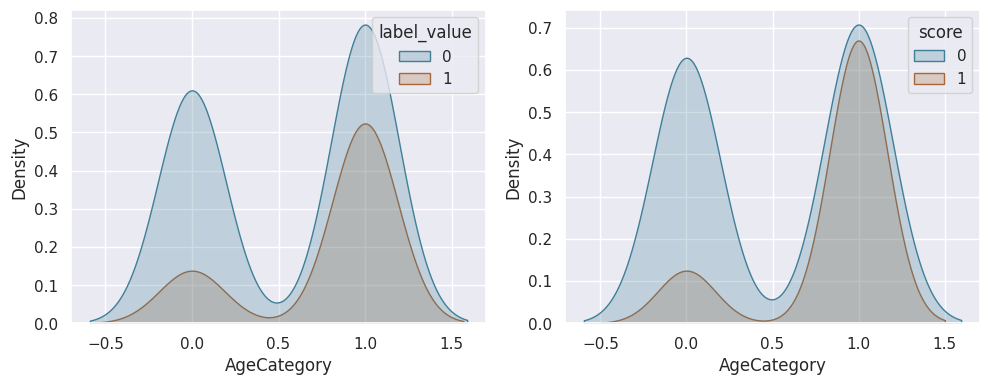

In [37]:
plt.figure(figsize=(15,15))
plt.subplot(4,3,1)
sns.kdeplot(data=preprocessed_df, x="AgeCategory", hue="label_value", fill=True, palette=aq_palette)
plt.subplot(4,3,2)
sns.kdeplot(data=preprocessed_df, x="AgeCategory", hue="score", fill=True, palette=aq_palette)
plt.tight_layout()

The first graph presents the distribution of people that really suffer from diabetes and those who don't, while the second shows the distribution of diabetic and non diabetic people predicted by our model.

It is evident that the graphs highlight a difference in density between the <font color=orange>predicted number of diabetics</font> and the <font color=orange>real one</font> for the people belonging to the *AgeCategory* of **1**, i.e. people that are over 25 years old.

This can be interpreted as a probable source of bias of our predictive model that we will investigate further on.

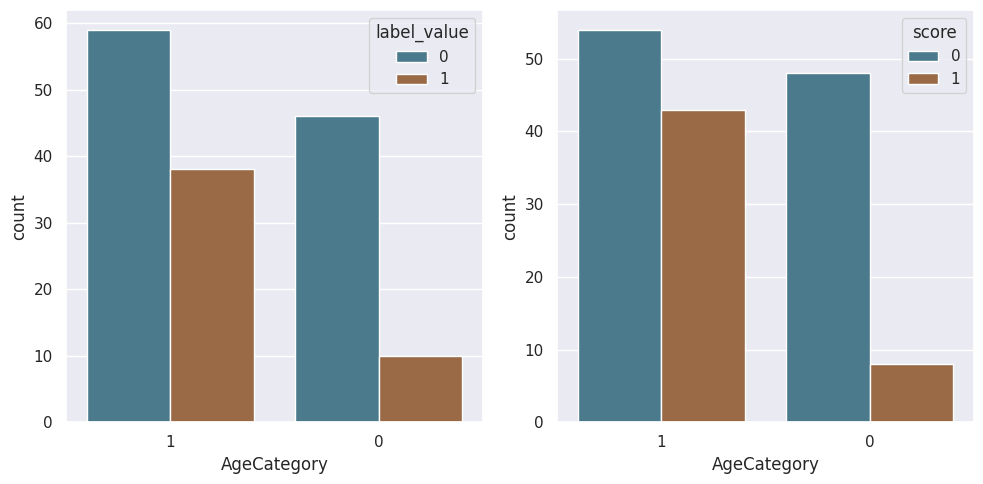

In [38]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
by_AgeCategory = sns.countplot(x="AgeCategory", hue="label_value", data=data, palette=aq_palette)
plt.subplot(1,2,2)
by_AgeCategory = sns.countplot(x="AgeCategory", hue="score", data=data, palette=aq_palette)
plt.tight_layout()

# <font color=#E00050>Auditing a Single Model using [Aequitas](http://www.datasciencepublicpolicy.org/projects/aequitas/)</font>
Aequitas can audit AI systems to look for biased actions or outcomes that are based on false or skewed assumptions about various demographic groups.

Applying Aequitas progammatically is a three step process represented by three python classes: 

`Group()`: Define groups 

`Bias()`: Calculate disparities

`Fairness()`: Assert fairness

## <font color=#85C1E9>Dataframe</font>
The initial audit is performed on the **whole dataframe** that will be sliced for further analyses on the sensitive attribute 

### <font color=#5DADE2>Define Attributes to Audit and Reference Group for each Attribute</font>
In order to audit the dataframe it's necessary to calculate disparities in relation to a specified group for each attribute.

Here groups have been selected mostly because they count the highest number of members overall the other groups (majority groups).

In [39]:
attributes_and_reference_groups={'Pregnancies':'0.00-1.00', 'Glucose':'99.00-115.00', 'BloodPressure':'64.00-72.00', 'SkinThickness':'10.00-23.00', 'Insulin':'16.00-30.50', 'BMI':'28.40-32.70', 'DiabetesPedigreeFunction':'0.08-0.24', 'Age':'37.00-65.00', 'AgeCategory':'1'}
attributes_to_audit = list(attributes_and_reference_groups.keys())

### <font color=#5DADE2>Define Groups</font>
`Group()` class assembles a confusion matrix of each subgroup, calculating commonly used metrics, counts by group and group prevelance among the sample population

The **`get_crosstabs()`** method tabulates a confusion matrix for each subgroup and calculates commonly used metrics.

It also provides counts by group and group prevelances:

In [100]:
g = Group()
xtab, _ = g.get_crosstabs(data, attr_cols=attributes_to_audit)



---


Store the names of the absolute metrics calculated:

In [101]:
abs_metrics = g.list_absolute_metrics(xtab)

### <font color=#5DADE2>Group Counts Calculated</font>
Calculated counts across sample population groups



The `group_measures` dataframe is retrived from the *xtab* previously generated by removing those columns related to the absolute metrics and other irrelevant ones:

In [42]:
group_measures = xtab[[ col for col in xtab.columns if col not in abs_metrics and col not in ['model_id','score_threshold','k'] ]]

Here's the content of the dataframe ***group_measures***:

| Count Type | Column Name |
| --- | --- |
| False Positive Count | 'fp' |
| False Negative Count | 'fn' |
| True Negative Count | 'tn' |
| True Positive Count | 'tp' |
| Predicted Positive Count | 'pp' |
| Predicted Negative Count | 'pn' |
| Count of Negative Labels in Group | 'group_label_neg' |
| Count of Positive Labels in Group | 'group_label_pos' | 
| Group Size | 'group_size'|
| Total Entities | 'total_entities' |

In [43]:
dff.format_blue_table(group_measures,list(),5,False,)

### <font color=#5DADE2>Absolute Metrics Calculated</font>
Calculated absolute metrics for each sample population group


Here are the absolute metrics calculated:

In [44]:
print(abs_metrics)

['tpr', 'tnr', 'for', 'fdr', 'fpr', 'fnr', 'npv', 'precision', 'ppr', 'pprev', 'prev']


| Metric | Column Name |
| --- | --- |
| True Positive Rate | 'tpr' |
| True Negative Rate | 'tnr' |
| False Omission Rate | 'for' |
| False Discovery Rate | 'fdr' |
| False Positive Rate | 'fpr' |
| False Negative Rate | 'fnr' |
| Negative Predictive Value | 'npv' |
| Precision | 'precision' |
| Predicted Positive Ratio$_k$ | 'ppr' |
| Predicted Positive Ratio$_g$ | 'pprev' |
| Group Prevalence | 'prev' |


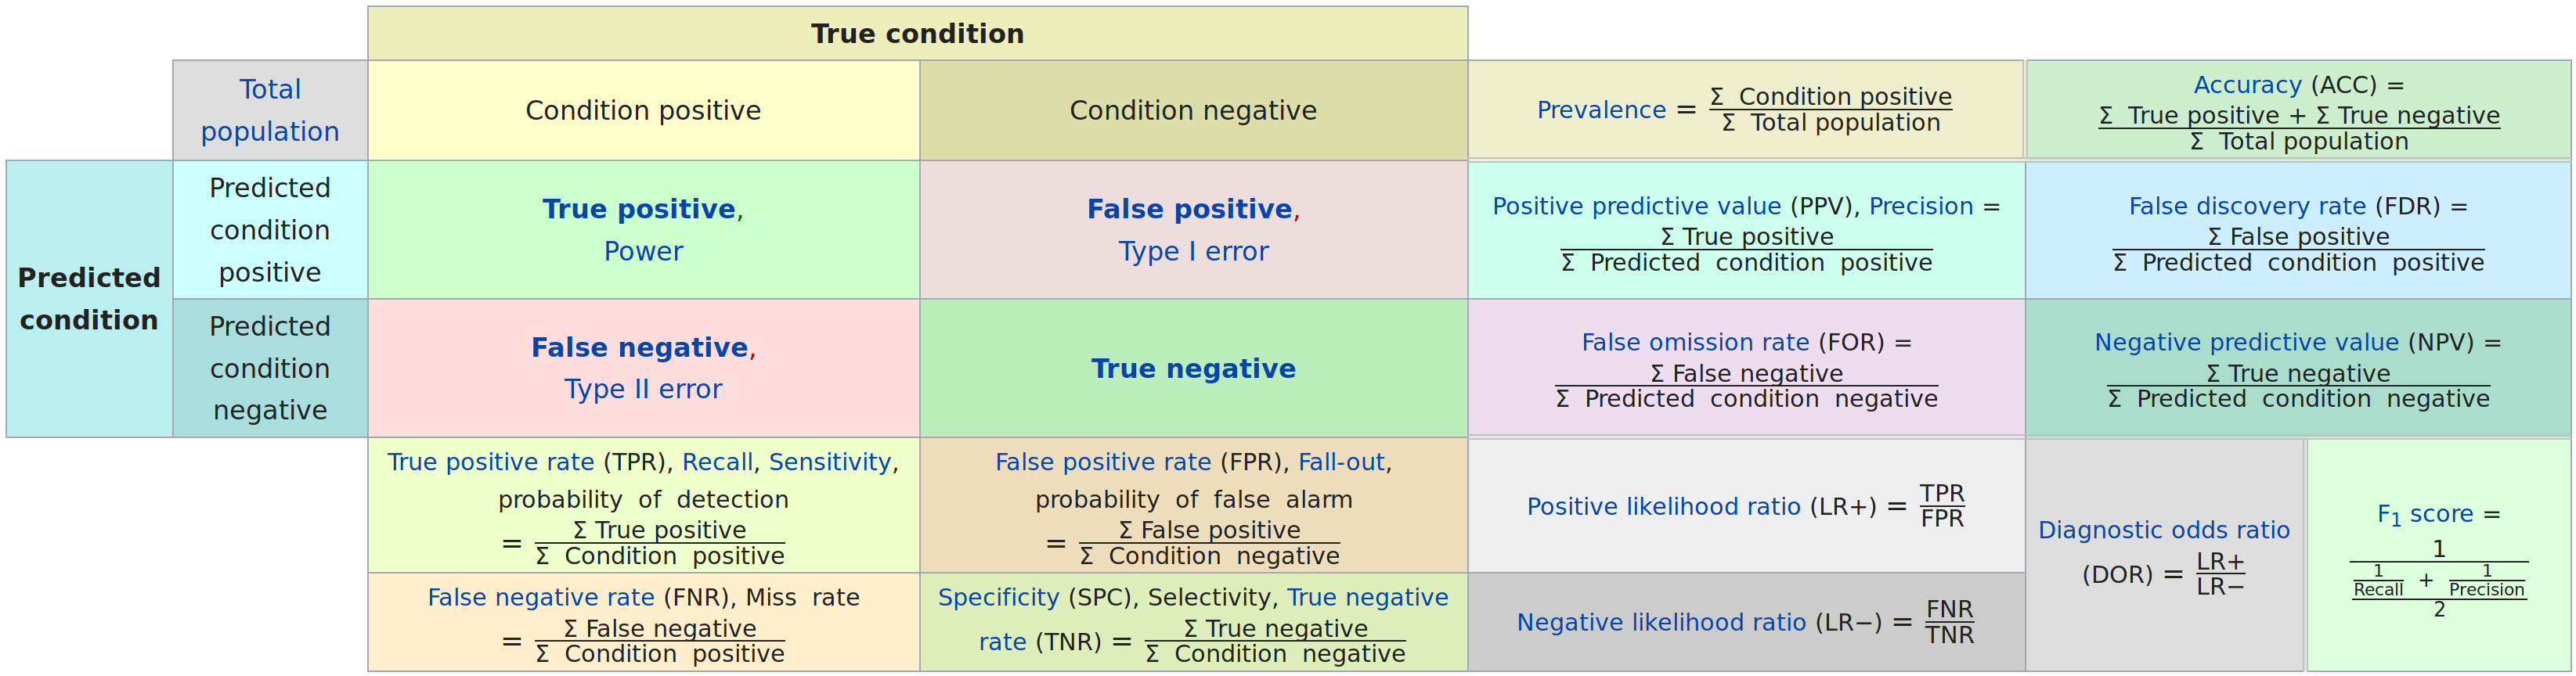


The `absolute_metrics` dataframe is retrived by slicing the `xtab` dataframe:

In [45]:
absolute_metrics = xtab[['attribute_name', 'attribute_value'] + abs_metrics]

Since the number of people involved in the *test set* is just 153 it happens to have group measures counts equal to 0, and that may cause problems for further calculation on group measures rates.

In order to solve this problem we simply replace *nan* values of the involved metrics with values of *0* or *1* that make their values meaningful:

In [46]:
absolute_metrics['fdr'] = absolute_metrics['fdr'].replace(np.nan,0)
absolute_metrics['precision'] = absolute_metrics['precision'].replace(np.nan,1)

In [47]:
dff.format_blue_table(absolute_metrics,abs_metrics,5,False)

The background gradient color has to be considered over each column of the absolute metrics, because the shading of the values is done column-wise, with `axis=0`.

### <font color=#5DADE2>Select fairness metric(s) that we care about</font>
Select the fairness metrics to be used to audit the system


As stated in the paper *Aequitas: A Bias and Fairness Audit Toolkit*:

> "The different fairness measures vary in importance to the end-user based on the cost and impact of the intervention. 
If the interventions are very expensive or could hurt the individuals, then we would want to minimize false positives (focusing on the False Discovery Rate and/or the False Positive Rate). 
If the interventions are predominantly **assistive**, we should be more concerned with **false negatives** (focusing on the False Omission Rate and/or the **False Negative Rate**)."

Since in this case the interventions are assistive and intervening with a big part of the population, the metric that fits the most is the **FNR**.

This can be easly detected exploiting the *FAIRNESS TREE* proposed in the paper:

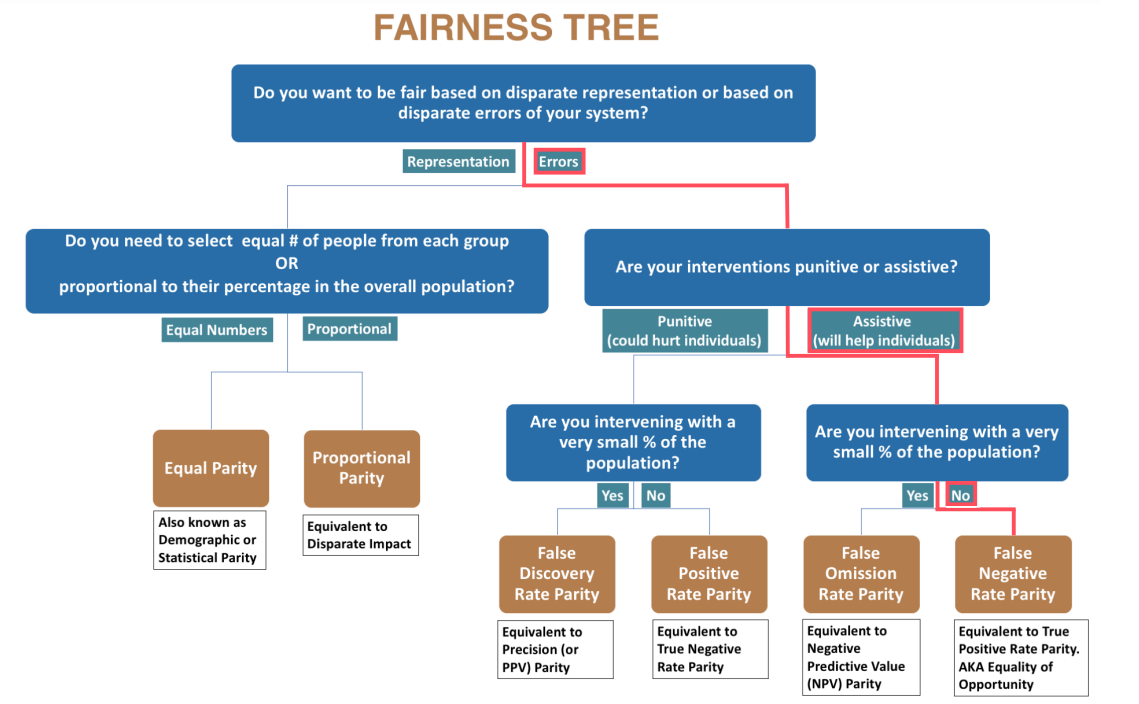

**False Negative Rate**

The fraction of false negatives of a group within the labeled positives of the group:

$$FNR_g = \frac{FN_g}{LP_g} = Pr(\hat{Y}=0—Y=1,A=a_i)$$


In [48]:
metrics = ['fnr']

**Equality of Opportunity** (i.e. True Positive rate Parity)

The protected and unprotected groups should have equal true positive rates (i.e. same rate of positive outcome, assuming the people in the groups qualify for the outcome):

$$TPR_g = \frac{TP_g}{LP_g} = Pr(\hat{Y}=1—Y=1,A=a_i)$$


Note that FNR parity is equivalent to TPR parity

In [49]:
metrics.append('tpr')

### <font color=#5DADE2>Calculate Disparities</font>
`Bias()` class permits to calculate disparities between groups based on the crosstab returned by the `Group()` class **`get_crosstabs()`** method described above. 

Disparities are calculated as a ratio of a metric for a group of interest compared to a base group. 

For example, the False Negative Rate Disparity for young vis-a-vis older people is:
$$Disparity_{FNR} =  \frac{FNR_{young}}{FNR_{old}}$$ 


In [50]:
%%capture
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, 
                                        original_df=data, 
                                        ref_groups_dict=attributes_and_reference_groups,
                                        alpha=0.05, 
                                        check_significance=True, 
                                        mask_significance=True)

Fixing some *nan* values caused, as mentioned before, by the presence of 0 values in the group count calculations that when at the divider in the disparities calculations cause *nan* values generation:

In [51]:
bdf['fdr_disparity'] = bdf['fdr_disparity'].replace(np.nan,0)
bdf['precision_disparity'] = bdf['precision_disparity'].replace(np.nan,1)
bdf['tpr_disparity'] = bdf['tpr_disparity'].replace(0,0.000001)

Store in lists the names of the disparities that have been calculated and their signifiance:

In [52]:
calculated_disparities = b.list_disparities(bdf)
disparity_significance = b.list_significance(bdf)

Disparities Calculated:

| Metric | Column Name |
| --- | --- |
| True Positive Rate Disparity | 'tpr_disaprity' |
| True Negative Rate Disparity | 'tnr_disparity' |
| False Omission Rate Disparity | 'for_disparity' |
| False Discovery Rate Disparity | 'fdr_disparity' |
| False Positive Rate Disparity | 'fpr_disparity' |
| False NegativeRat Disparitye | 'fnr_disparity' |
| Negative Predictive Value Disparity | 'npv_disparity' |
| Precision Disparity | 'precision_disparity' |
| Predicted Positive Ratio$_k$ Disparity | 'ppr_disparity' |
| Predicted Positive Ratio$_g$ Disparity | 'pprev_disparity' |

**Calculated disparities dataframe**

In [53]:
disparities = bdf[['attribute_name', 'attribute_value'] + calculated_disparities]

Here in a gray table format in order to highlight better the differences in values of each disparity using the text gradient: 

In [54]:
dff.format_gray_table(disparities,calculated_disparities,5,False)

Here instead in a blue table format in order to focus easily on the percentage difference of each value within each column:

In [55]:
dff.format_blue_table(disparities,calculated_disparities,5,False)

**Disparities significance dataframe**

In [56]:
significance = bdf[['attribute_name', 'attribute_value'] + disparity_significance]

In [57]:
dff.format_gray_table(significance,list(),5,False)

### <font color=#5DADE2>Assert Fairness</font>
`Fairness()` class provides three functions that provide a high level summary of fairness:

1.   Group Level Fairness
2.   Attribute Level Fairness
3.   Overall Fairness



In [58]:
f = Fairness()

#### <font color=#85C1E9>Group Level Fairness</font>

In [59]:
fdf = f.get_group_value_fairness(bdf)

List of **Parities Calcuated:**

| Parity | Column Name |
| --- | --- |
| True Positive Rate Parity | ‘TPR Parity’ |
| True Negative Rate Parity | ‘TNR Parity’ |
| False Omission Rate Parity | ‘FOR Parity’ | 
| False Discovery Rate Parity | ‘FDR Parity’ |
| False Positive Rate Parity | ‘FPR Parity’ |
| False Negative Rate Parity | ‘FNR Parity’ |
| Negative Predictive Value Parity | ‘NPV Parity’ |
| Precision Parity | ‘Precision Parity’ |
| Predicted Positive Ratio_k Parity | ‘Statistical Parity’ |
| Predicted Positive Ratio_g Parity | ‘Impact Parity’ |

It's also assessed:

| Column Name | Description |
| --- | --- |
| Type I Parity | Fairness in both FDR Parity and FPR Parity |
| Type II Parity | Fairness in both FOR Parity and FNR Parity |
| Equalized Odds | Fairness in both FPR Parity and TPR Parity |
| Unsupervised Fairness | Fairness in both Statistical Parity and Impact Parity|
| Supervised Fairness | Fairness in both Type I and Type II Parity |
| Overall Fairness | Fairness across all parities for all attributes |

In [60]:
parity_detrminations = f.list_parities(fdf)

In [61]:
gvf = fdf[['attribute_name', 'attribute_value'] + parity_detrminations]
dff.format_gray_table(gvf,list(),5,False)

#### <font color=#85C1E9>Attribute Level Fairness</font>

In [62]:
gaf = f.get_group_attribute_fairness(fdf)

In [63]:
gaf = gaf[['attribute_name'] + parity_detrminations]
dff.format_gray_table(gaf,list(),5,False)

#### <font color=#85C1E9>Overall Fairness</font>

In [64]:
gof = f.get_overall_fairness(fdf)
gof

{'Unsupervised Fairness': False,
 'Supervised Fairness': False,
 'Overall Fairness': False}

### <font color=#5DADE2>Disparity Tolerance choice</font>
The formulation and implementation of fairness is flexible as it relies on a real valued parameter $\tau ∈ (0, 1]$ to control the range of disparity values that can be considered fair.

An example of formulation of disparity is using the “80% rule” represented by $\tau = 0.8$. 

This notion of parity requires that all biases to be within the range defined by $\tau$:

$$ \tau ≤ DisparityMeasure_{group_i} ≤ \frac{1}{\tau} $$

$$ 0.8 ≤ DisparityMeasure_{group_i} ≤ \frac{1}{0.8} = 1.25 $$

In [65]:
disparity_tolerance = 1.25

### <font color=#F14B31>Dataset Exploration with Aequitas</font>
A quick overview using Aequitas to analyze the dataframe

Visualizing disparities between all groups for a single disparity metric:

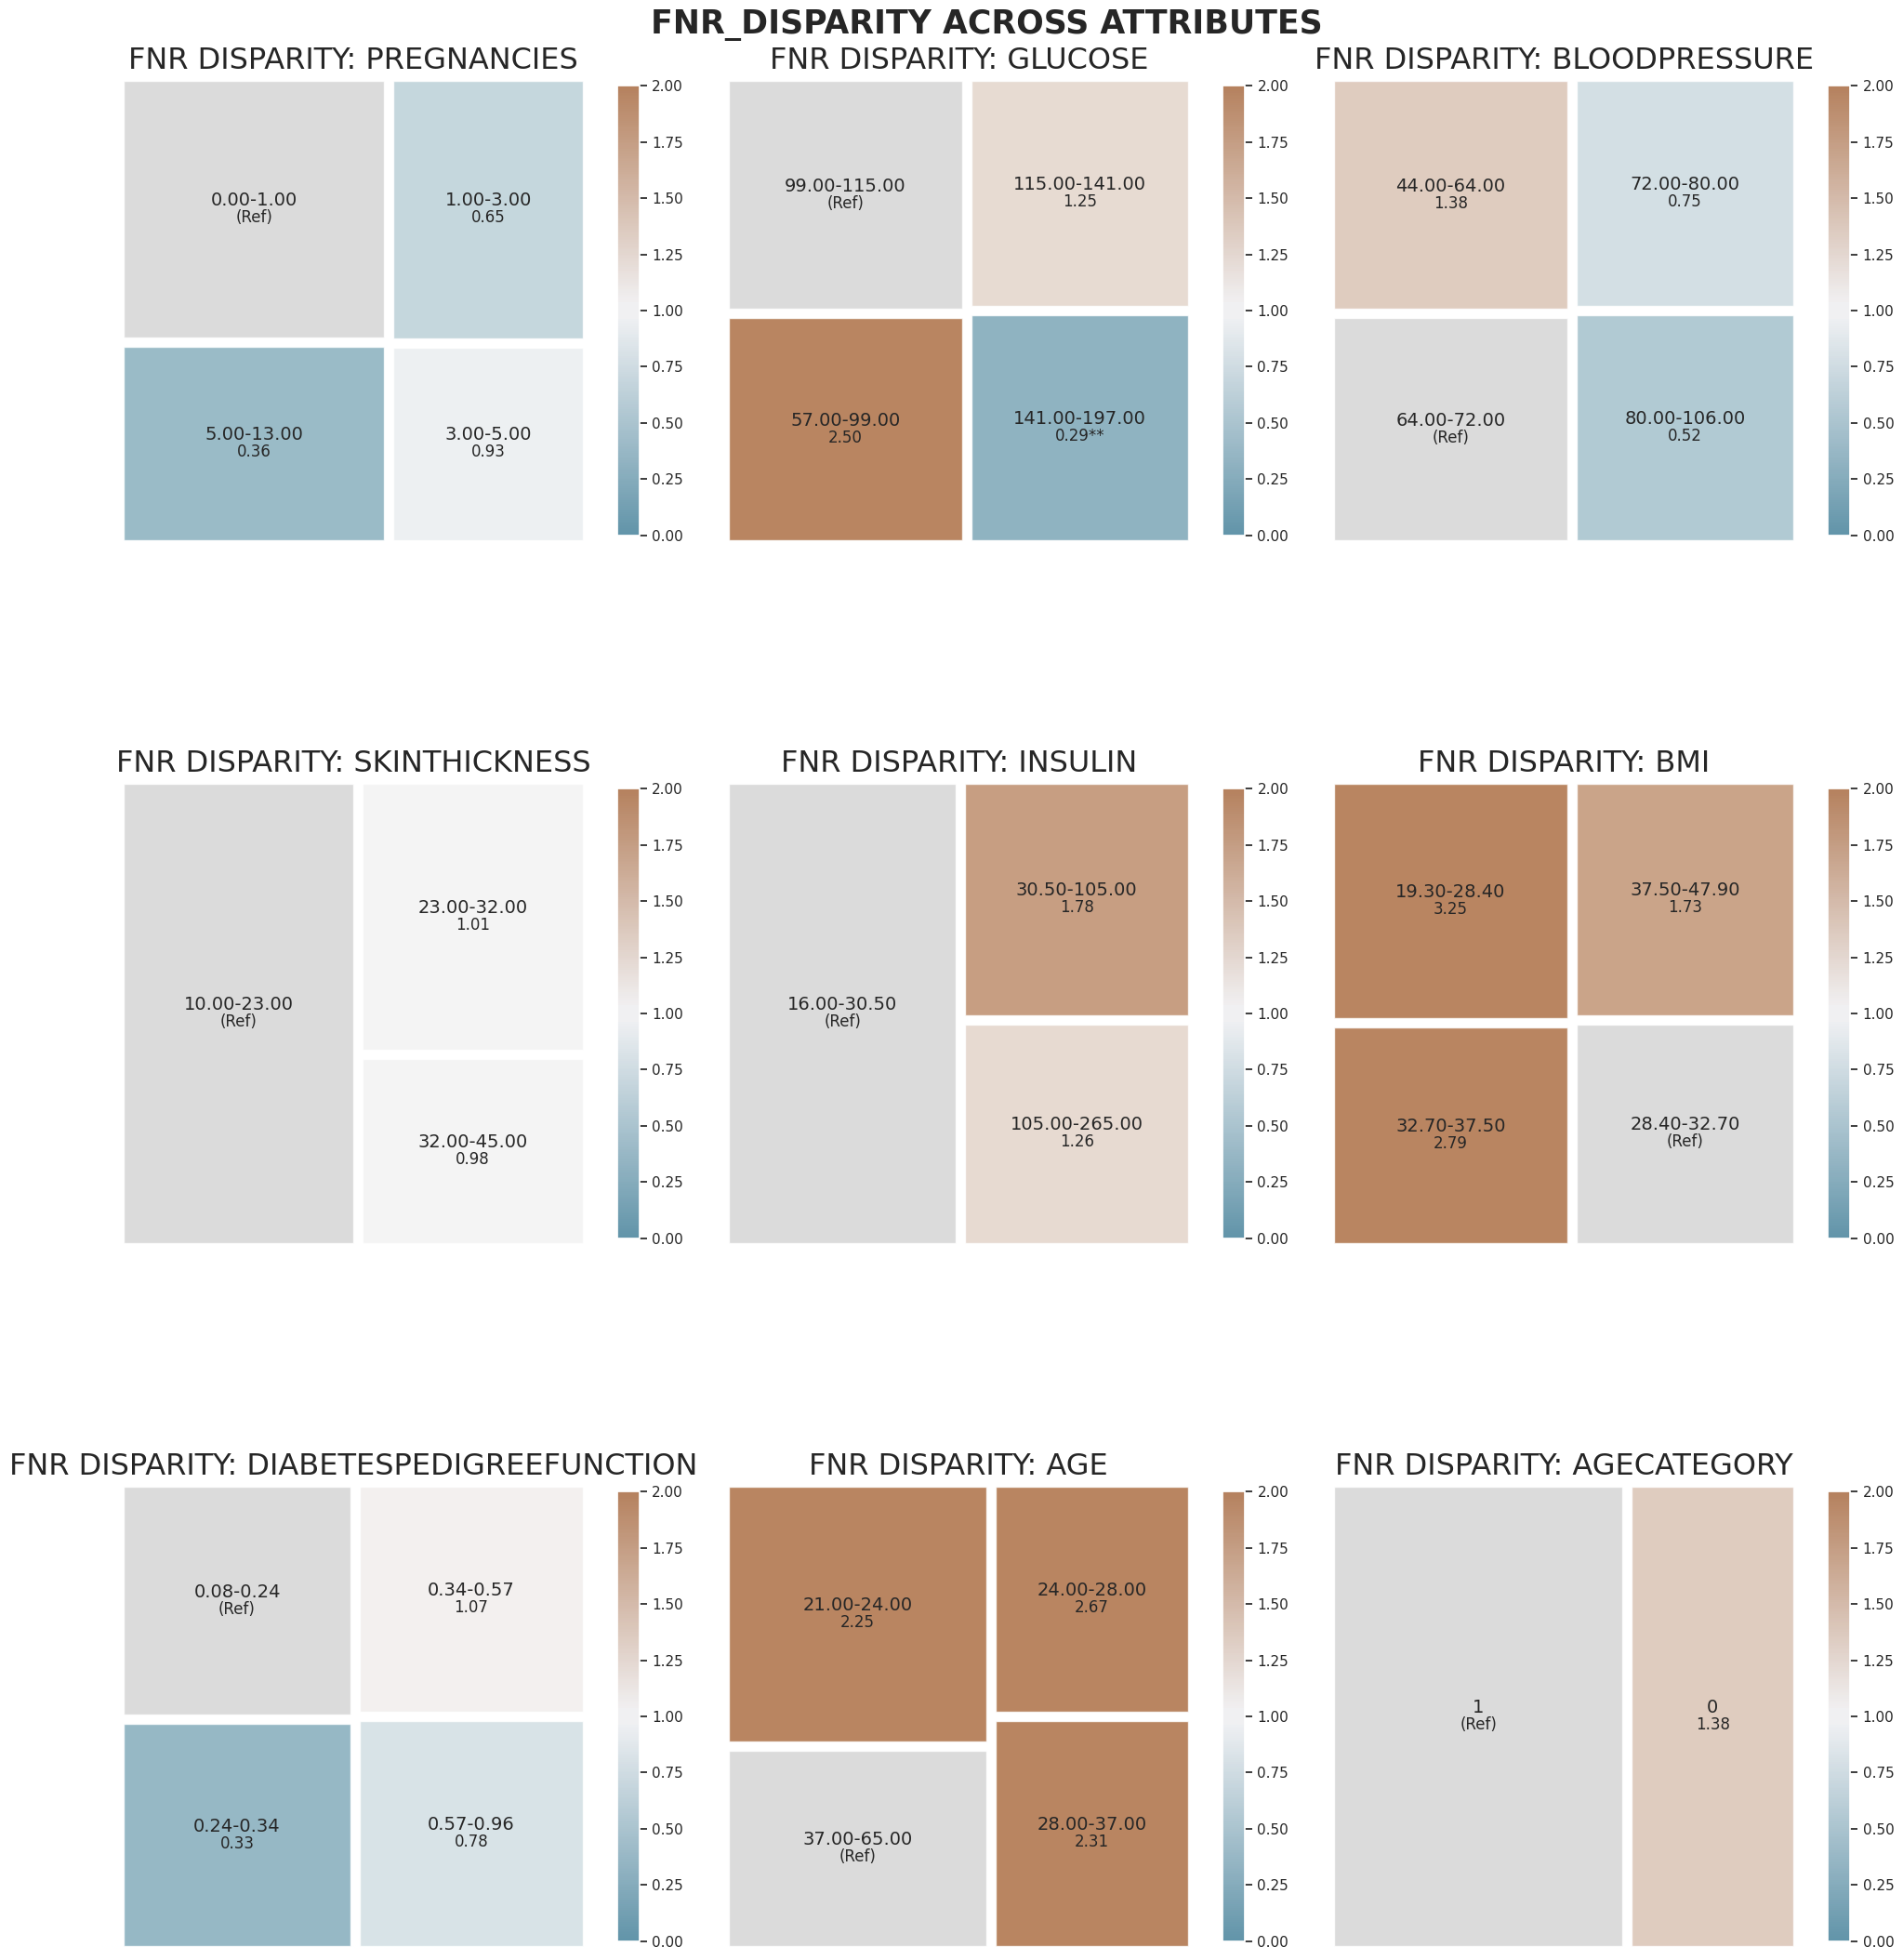

In [69]:
fnr_d = aqp.plot_disparity_all(bdf, metrics=['fnr_disparity'], significance_alpha=0.05)

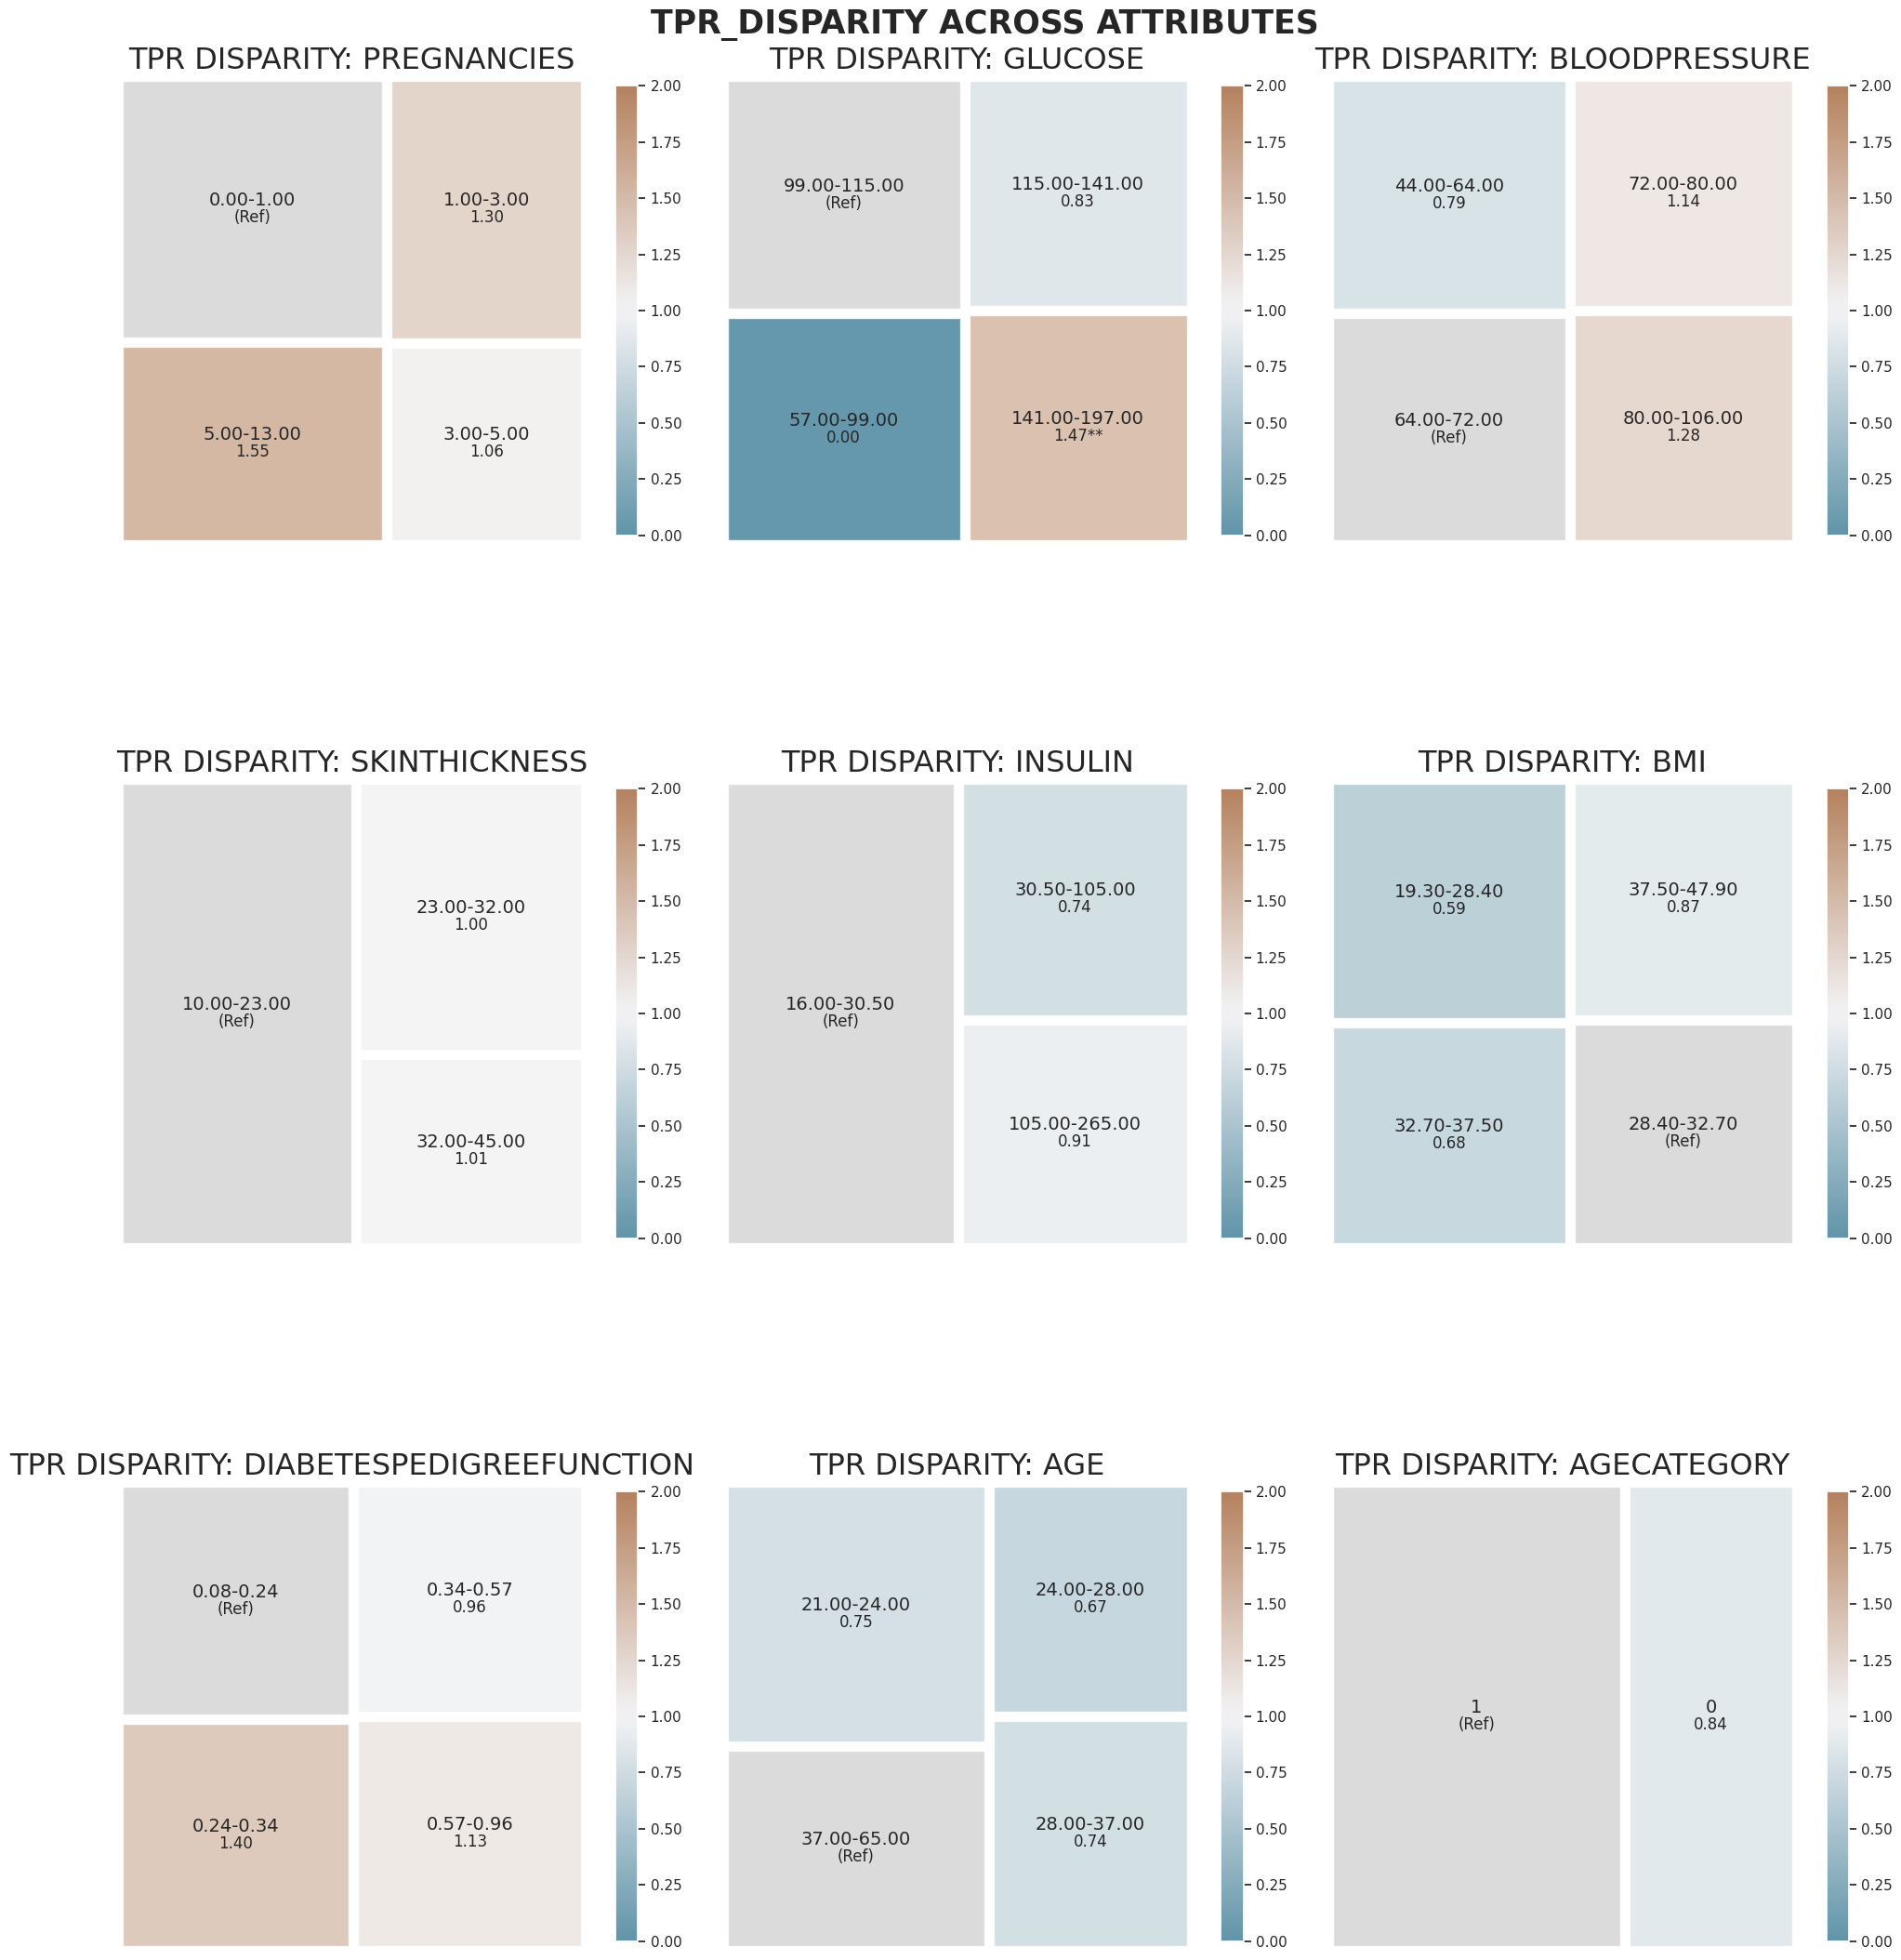

In [70]:
tpr_d = aqp.plot_disparity_all(bdf, metrics=['tpr_disparity'], significance_alpha=0.05)

Visualizing a summary for the parity of a single absolute group metric across all population groups:

In [99]:
ap.summary(bdf, metrics, fairness_threshold = disparity_tolerance)

alt.VConcatChart(...)

## <font color=#85C1E9>Sensitive Attribute</font>
The audit is performed only on the sensitive attribute: ***AgeCategory***, the discriminations will be searched on it

In [96]:
print(sensitive_attribute)

AgeCategory


### <font color=#85C1E9>Sensitive Attribute Dataframes</font>
All the following tables comes from the process of slicing the previously obtained dataframes (Section: Dataframe).

Each section include also a brief description of the dataframe content in order to facilitate their read:

#### <font color=#5DADE2>Groups Defined</font>


In [76]:
xtab_sensitive = xtab[group_measures.attribute_name == sensitive_attribute]
dff.format_blue_table(xtab_sensitive,list(),2,True)

#### <font color=#5DADE2>Group Counts Calculated</font>



| Count Type | Column Name |
| --- | --- |
| False Positive Count | 'fp' |
| False Negative Count | 'fn' |
| True Negative Count | 'tn' |
| True Positive Count | 'tp' |
| Predicted Positive Count | 'pp' |
| Predicted Negative Count | 'pn' |
| Count of Negative Labels in Group | 'group_label_neg' |
| Count of Positive Labels in Group | 'group_label_pos' | 
| Group Size | 'group_size'|
| Total Entities | 'total_entities' |

In [77]:
group_measure_sensitive = group_measures[group_measures.attribute_name == sensitive_attribute]
dff.format_blue_table(group_measure_sensitive,list(),2,True)

#### <font color=#5DADE2>Absolute Metrics Calculated</font>


| Metric | Column Name |
| --- | --- |
| True Positive Rate | 'tpr' |
| True Negative Rate | 'tnr' |
| False Omission Rate | 'for' |
| False Discovery Rate | 'fdr' |
| False Positive Rate | 'fpr' |
| False Negative Rate | 'fnr' |
| Negative Predictive Value | 'npv' |
| Precision | 'precision' |
| Predicted Positive Ratio$_k$ | 'ppr' |
| Predicted Positive Ratio$_g$ | 'pprev' |
| Group Prevalence | 'prev' |

In [78]:
absolute_metrics_sensitive = absolute_metrics[absolute_metrics.attribute_name == sensitive_attribute]
dff.format_blue_table(absolute_metrics_sensitive, abs_metrics,2,True)

Shading all values collectively using `axis=None`.

#### <font color=#5DADE2>Calculate Disparities</font>


| Metric | Column Name |
| --- | --- |
| True Positive Rate Disparity | 'tpr_disaprity' |
| True Negative Rate Disparity | 'tnr_disparity' |
| False Omission Rate Disparity | 'for_disparity' |
| False Discovery Rate Disparity | 'fdr_disparity' |
| False Positive Rate Disparity | 'fpr_disparity' |
| False NegativeRat Disparitye | 'fnr_disparity' |
| Negative Predictive Value Disparity | 'npv_disparity' |
| Precision Disparity | 'precision_disparity' |
| Predicted Positive Ratio$_k$ Disparity | 'ppr_disparity' |
| Predicted Positive Ratio$_g$ Disparity | 'pprev_disparity' |

In [79]:
disparities_sensitive = disparities[disparities.attribute_name == sensitive_attribute]
dff.format_gray_table(disparities_sensitive,calculated_disparities,2,True)

#### <font color=#5DADE2>Group Fairness</font>


| Parity | Column Name |
| --- | --- |
| True Positive Rate Parity | ‘TPR Parity’ |
| True Negative Rate Parity | ‘TNR Parity’ |
| False Omission Rate Parity | ‘FOR Parity’ | 
| False Discovery Rate Parity | ‘FDR Parity’ |
| False Positive Rate Parity | ‘FPR Parity’ |
| False Negative Rate Parity | ‘FNR Parity’ |
| Negative Predictive Value Parity | ‘NPV Parity’ |
| Precision Parity | ‘Precision Parity’ |
| Predicted Positive Ratio_k Parity | ‘Statistical Parity’ |
| Predicted Positive Ratio_g Parity | ‘Impact Parity’ |

---

| Column Name | Description |
| --- | --- |
| Type I Parity | Fairness in both FDR Parity and FPR Parity |
| Type II Parity | Fairness in both FOR Parity and FNR Parity |
| Equalized Odds | Fairness in both FPR Parity and TPR Parity |
| Unsupervised Fairness | Fairness in both Statistical Parity and Impact Parity|
| Supervised Fairness | Fairness in both Type I and Type II Parity |
| Overall Fairness | Fairness across all parities for all attributes |

In [80]:
gaf_sensitive = gaf[gaf.attribute_name == sensitive_attribute]
dff.format_gray_table(gaf_sensitive,list(),1,True)

#### <font color=#5DADE2>Disparities Significance</font>


In [81]:
significance_sensitive = significance[significance.attribute_name == sensitive_attribute]
dff.format_gray_table(significance_sensitive,list(),2,True)

### <font color=#F14B31>Analisys on results</font>
The most significant section where the Aequitas Plotting toolkit is used to audit the fairness of the dataframe

A simple dictionary to better visualize and understand the meaning of the labels:

In [82]:
dictionary = {
  "0": "YOUNGER",
  "1": "OLDER"
}

#### <font color=#FA786D>Group Metric Plots</font> 

Visualizing all absolute group metrics across all population groups:

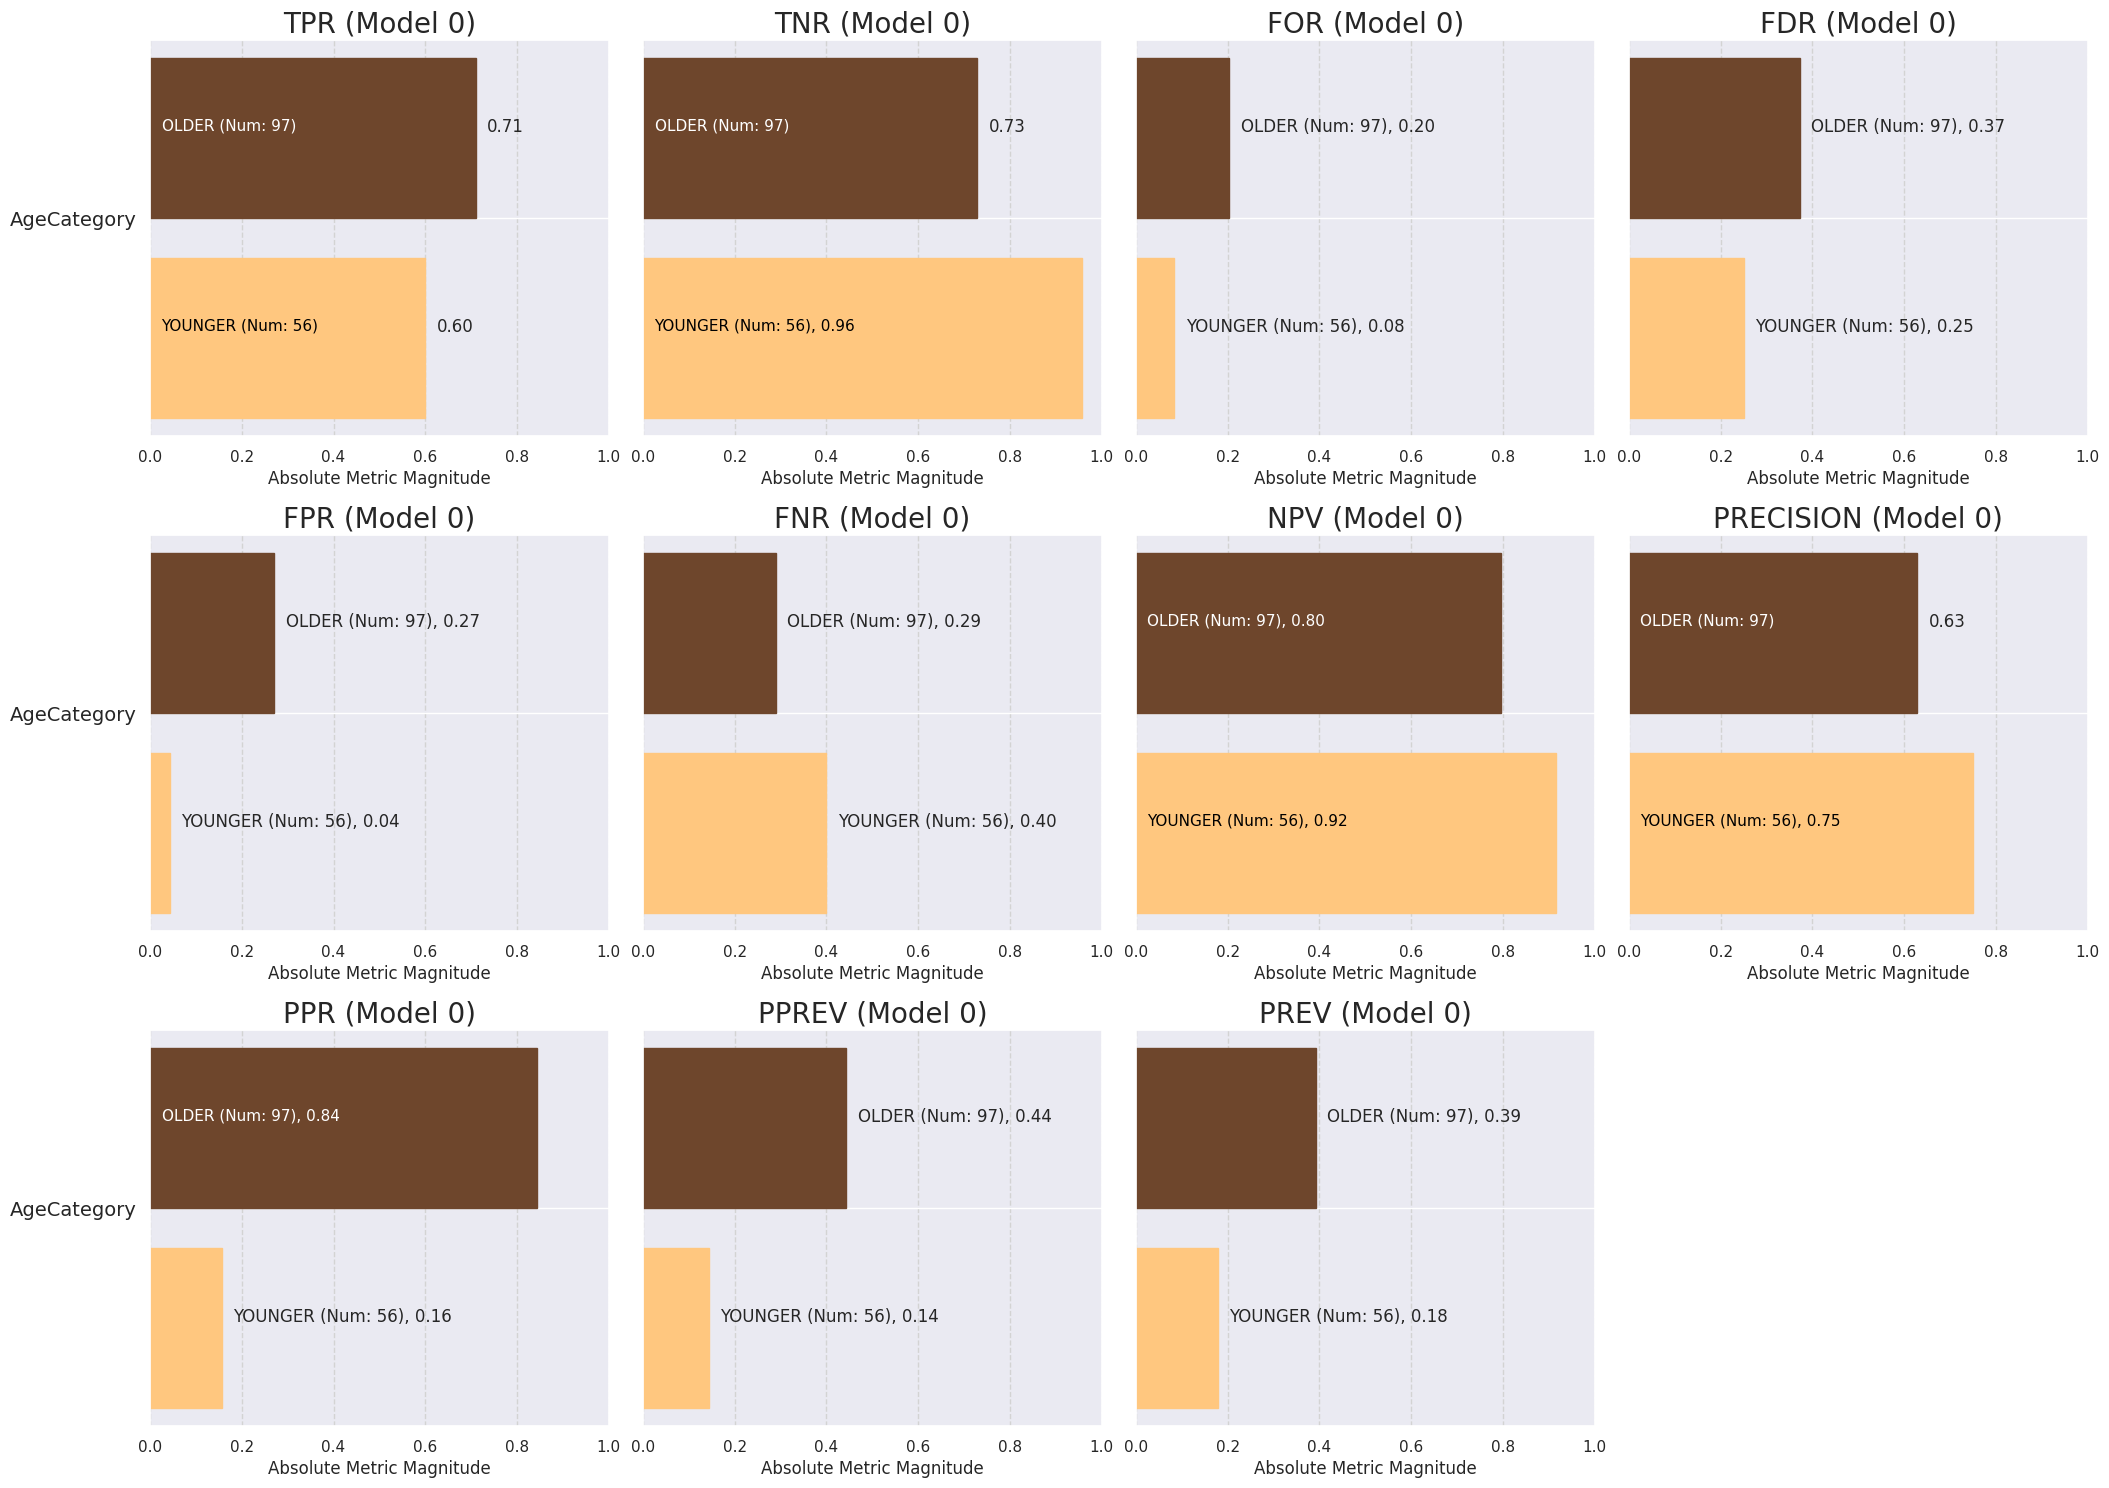

<Figure size 1000x1000 with 0 Axes>

In [83]:
a = aqp.plot_group_metric_all(xtab_sensitive, metrics=abs_metrics, ncols=4, label_dict=dictionary)

Note that dark brown color of **OLDER** group means a greater number of partecipant to that group (97) with respect to the other one (56).

---

**PPREV** is the fraction of entities within a group which were predicted as positive

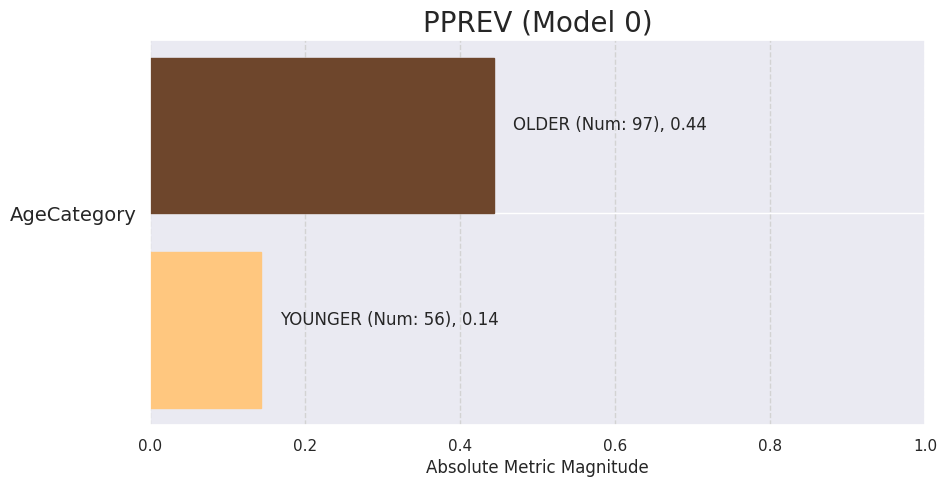

In [84]:
pprev = aqp.plot_group_metric(xtab_sensitive, 'pprev', label_dict=dictionary)

It's clear from the graph that in the group composed by people over 25 the percentage of diabetic person is drastically high.

We can state that in our model almost **4.5 out of 10** people **over 25** have been predicted to be diabetic, whilst only **1.5 out of 10** people **under 25** have been labeled as diabetic.

This information itself does not imply that our model is biased against older people, but it means that the tendency to be diabetic increases with age, and this could be a source of prejudice within our model.

---

Focus on interesting metrics:

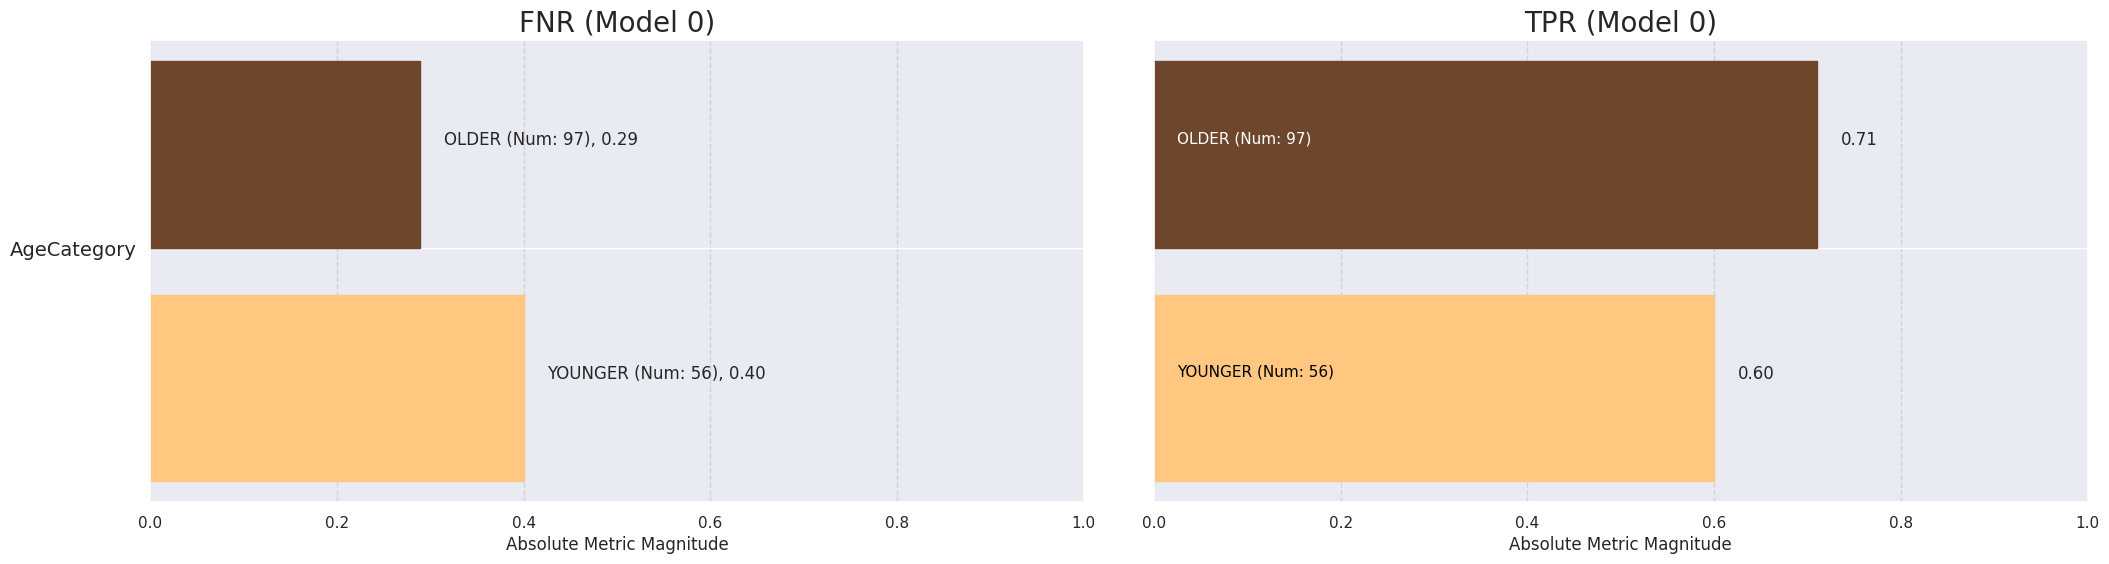

<Figure size 1000x1000 with 0 Axes>

In [85]:
fnr_tpr = aqp.plot_group_metric_all(xtab_sensitive, metrics=metrics, ncols=2, label_dict=dictionary)

These are the measure that will be used to audit the fairness of the system.

* **FNR** presents a greater value for the **YOUNGER** group, this means that in that group the quantity of **FN**s (false negatives) over **LP$_g$**s (group_label_pos) is higher with respect to the **OLDER** one:

$$ \boldsymbol{YOUNGER} = \frac{4}{10} = 0.40  \quad \boldsymbol>  \quad  0.29 = \frac{11}{38} = \boldsymbol{OLDER}$$


* **TPR** is slightly greater for the **OLDER** group and that is due to the fact that ratio between its **TP**s (true positives) and its **LP$_g$**s (group_label_pos) is higher then the **YOUNGER** one:

$$ \boldsymbol{OLDER} = \frac{27}{38} = 0.71  \quad \boldsymbol>  \quad  0.6 = \frac{6}{10} = \boldsymbol{YOUNGER}$$

#### <font color=#FA786D>Disparity Plots</font> 

Visualizing disparities between groups in a single attribute for all calculated disparity metrics:

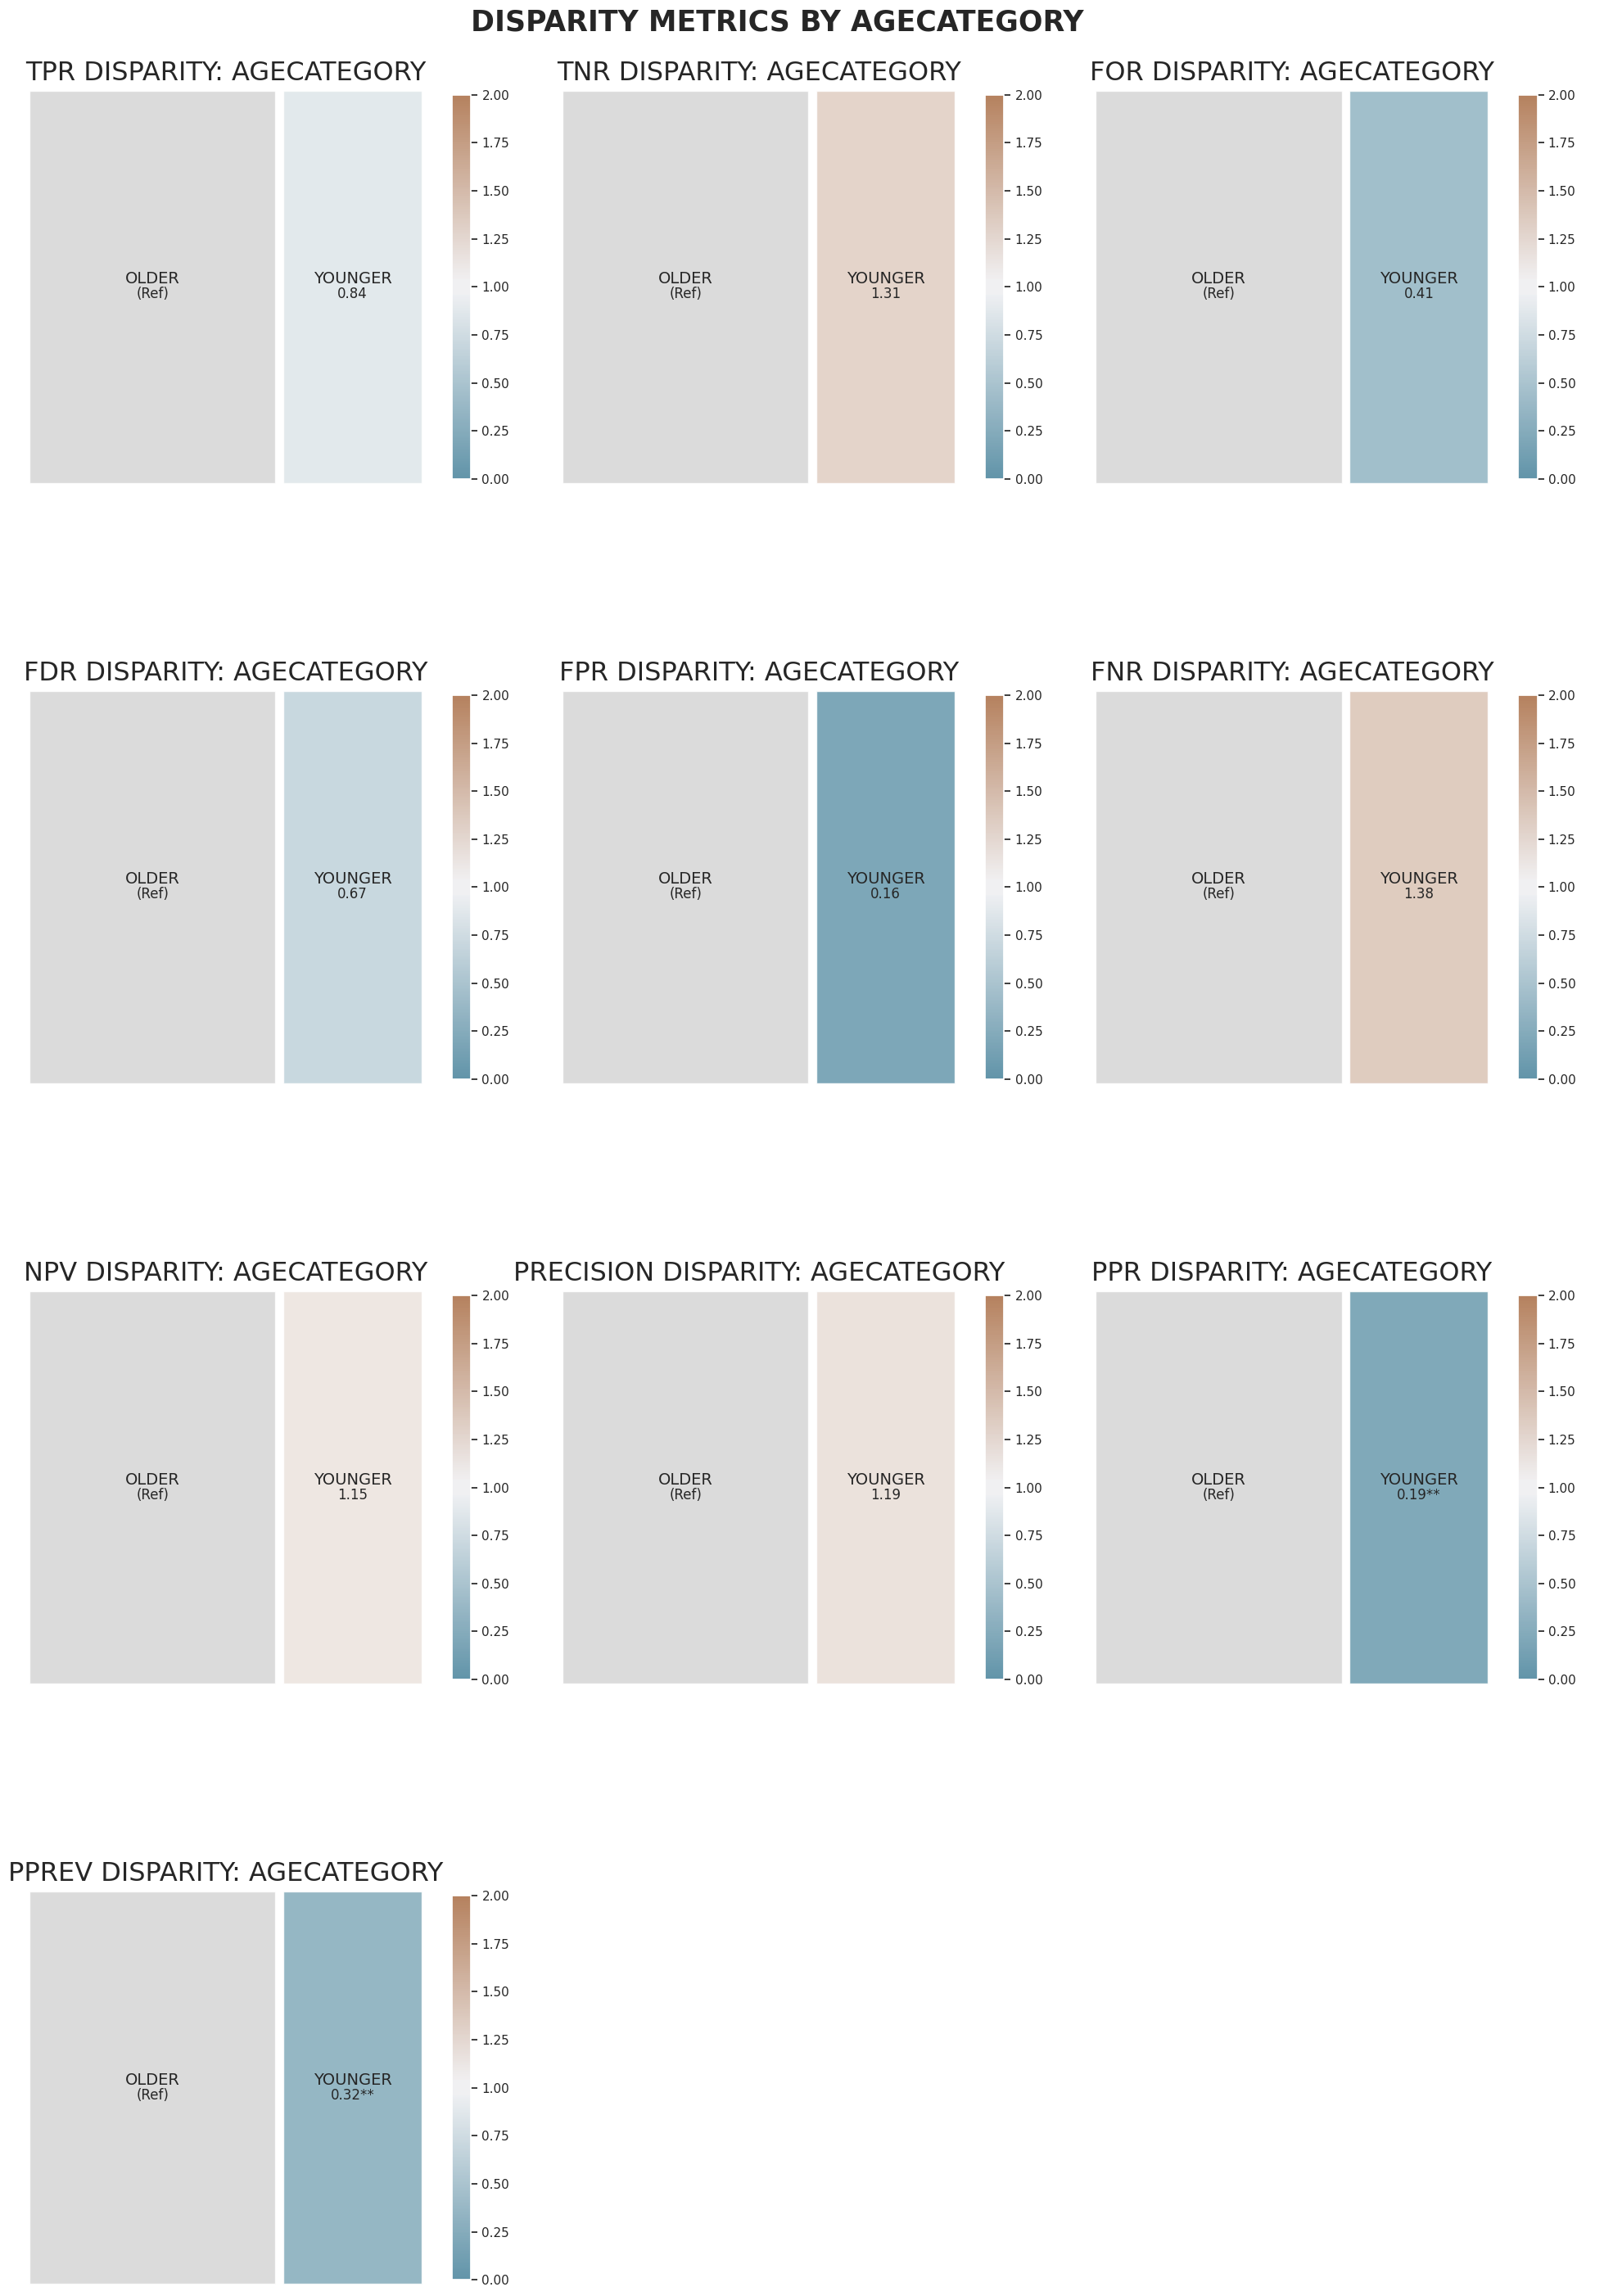

In [86]:
tm_capped = aqp.plot_disparity_all(bdf, attributes=[sensitive_attribute], metrics = 'all', significance_alpha=0.05, label_dict=dictionary)

Disparities are calculated using the **OLDER** group as reference group.

The treemaps above display disparities between *AgeCategory* attribute groups calculated based on predefined reference groups (*AgeCategory* = 1) for all 10 disparity metrics, colored based on disparity magnitude.

Values vary between 0 and 2 in this way:

*  **Around 0** values mean lower disparities with respect to the reference group and are colored in <font color=lightblue>light blue</font>

*  **Around 1** values mean disparities values near to the reference group and are colored in <font color=gray>gray</font>

*  **Around 2** values mean higher disparities with respect to the reference group and are colored in <font color=orange>orange</font>

---

Focus on interesting metrics:

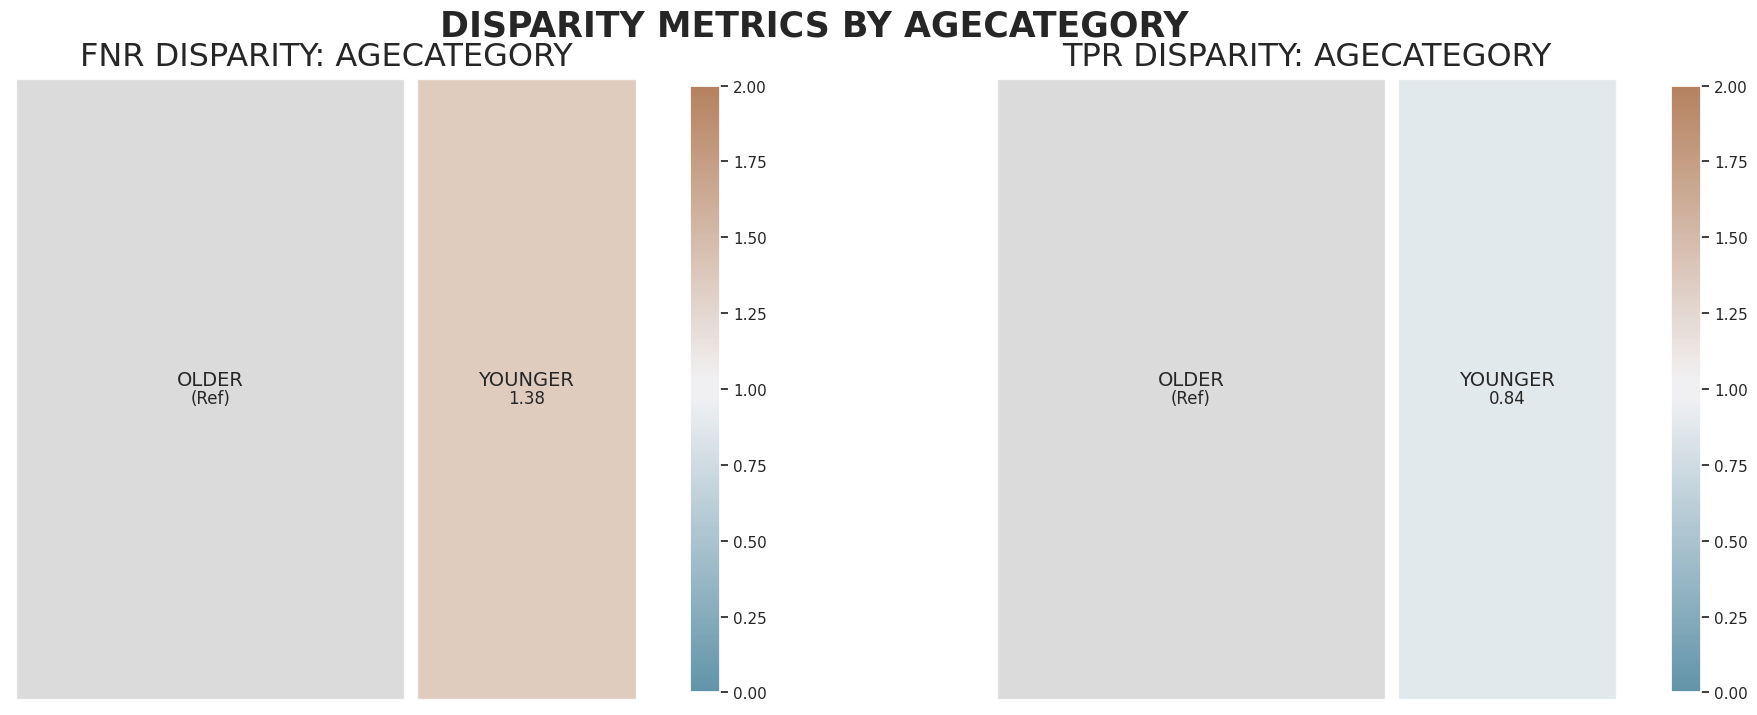

In [87]:
tm_capped = aqp.plot_disparity_all(bdf, attributes=[sensitive_attribute], metrics=['fnr_disparity','tpr_disparity'], significance_alpha=0.05, label_dict=dictionary)

From this plot we can see that **YOUNGER** people are **1.38** times more likely to be falsely identified not diabetic as **OLDER** people are.

**YOUNGER** people are also **0.84** times less likely to be labeled diabetes-positive when they really are with respect to **OLDER** ones.

#### <font color=#FA786D>Fairness Group Plots</font> 

Slicing the fairness dataframe previously obtained with the function ``get_group_value_fairness()``:

In [88]:
fdf_sensitive = fdf[group_measures.attribute_name == sensitive_attribute]

Visualizing all absolute group metrics across the sensitive attribute, colored based on fairness determination for that attribute group (<font color=green>green</font> = <font color=green>‘True’</font> and <font color=red>red</font> = <font color=red>‘False’</font>):

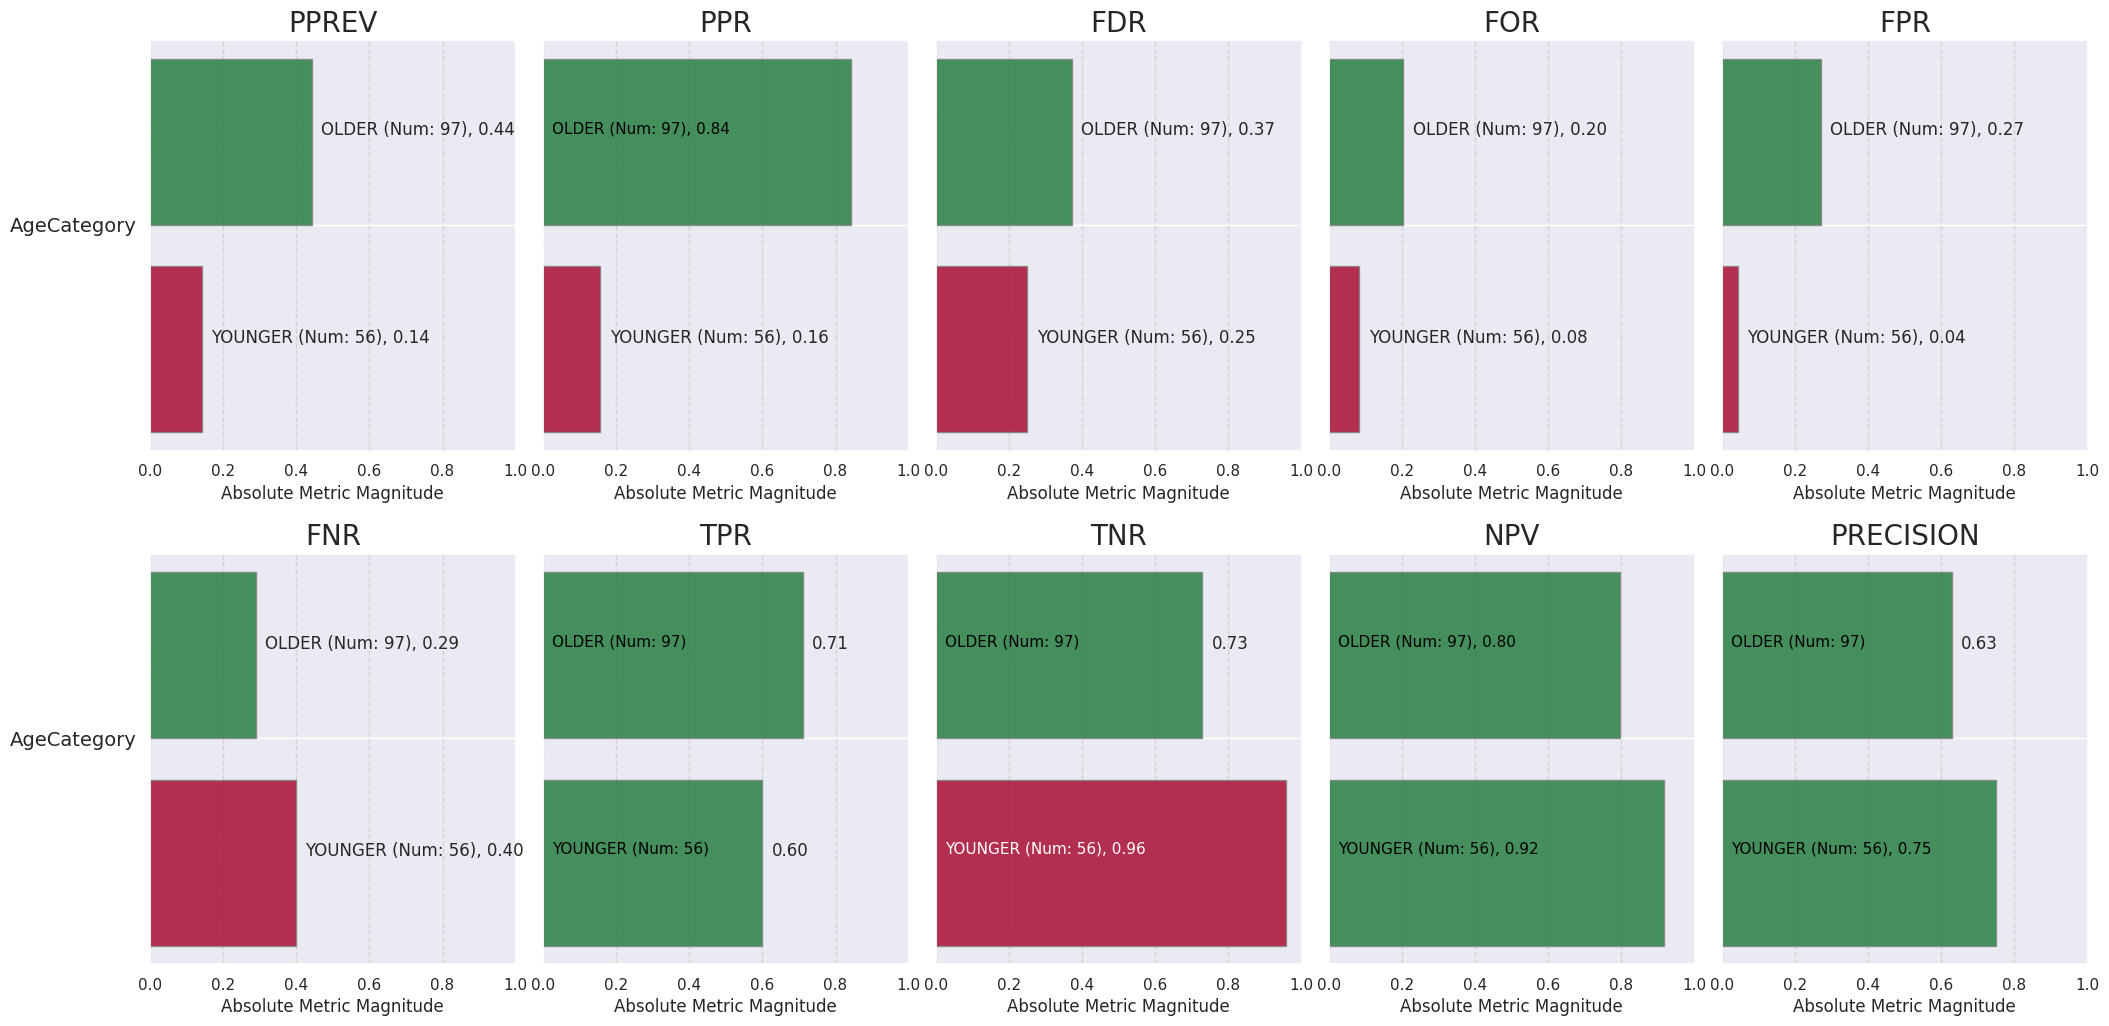

<Figure size 1000x1000 with 0 Axes>

In [89]:
all_f = aqp.plot_fairness_group_all(fdf_sensitive, ncols=5, metrics = "all", label_dict=dictionary)

Focus on interesting metrics:

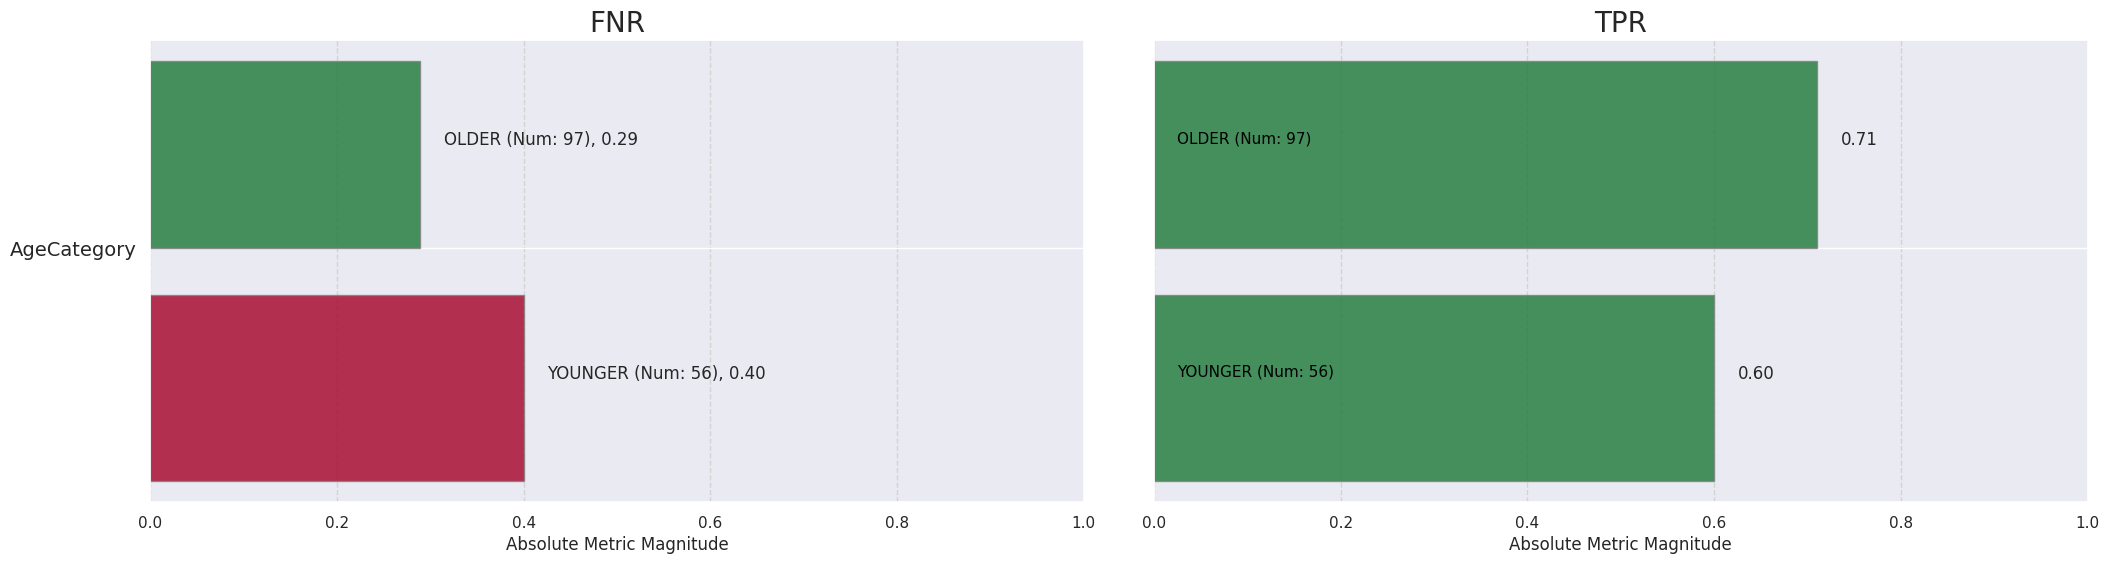

<Figure size 1000x1000 with 0 Axes>

In [90]:
all_f = aqp.plot_fairness_group_all(fdf_sensitive, ncols=2, metrics = metrics, label_dict=dictionary)

**FNR:**
>The **OLDER** group (i.e. the reference one) is determined to be fair obviously.
On the other hand the **YOUNGER** group has been determined to be not fair.

>This means that our model is biased on **AgeCategory**'s **FNR** against younger people.


**TPR:**
>Both groups have been determined to be fair

>This means that our model isn't biased on **AgeCategory**'s **TPR**.

#### <font color=#FA786D>Fairness Disparity Plots</font> 

Visualizing parity between groups in the sensitive attribute for all calculated disparity metrics, colored based on fairness determination for that attribute group (<font color=green>green</font> = <font color=green>‘True’</font> and <font color=red>red</font> = <font color=red>‘False’</font>):

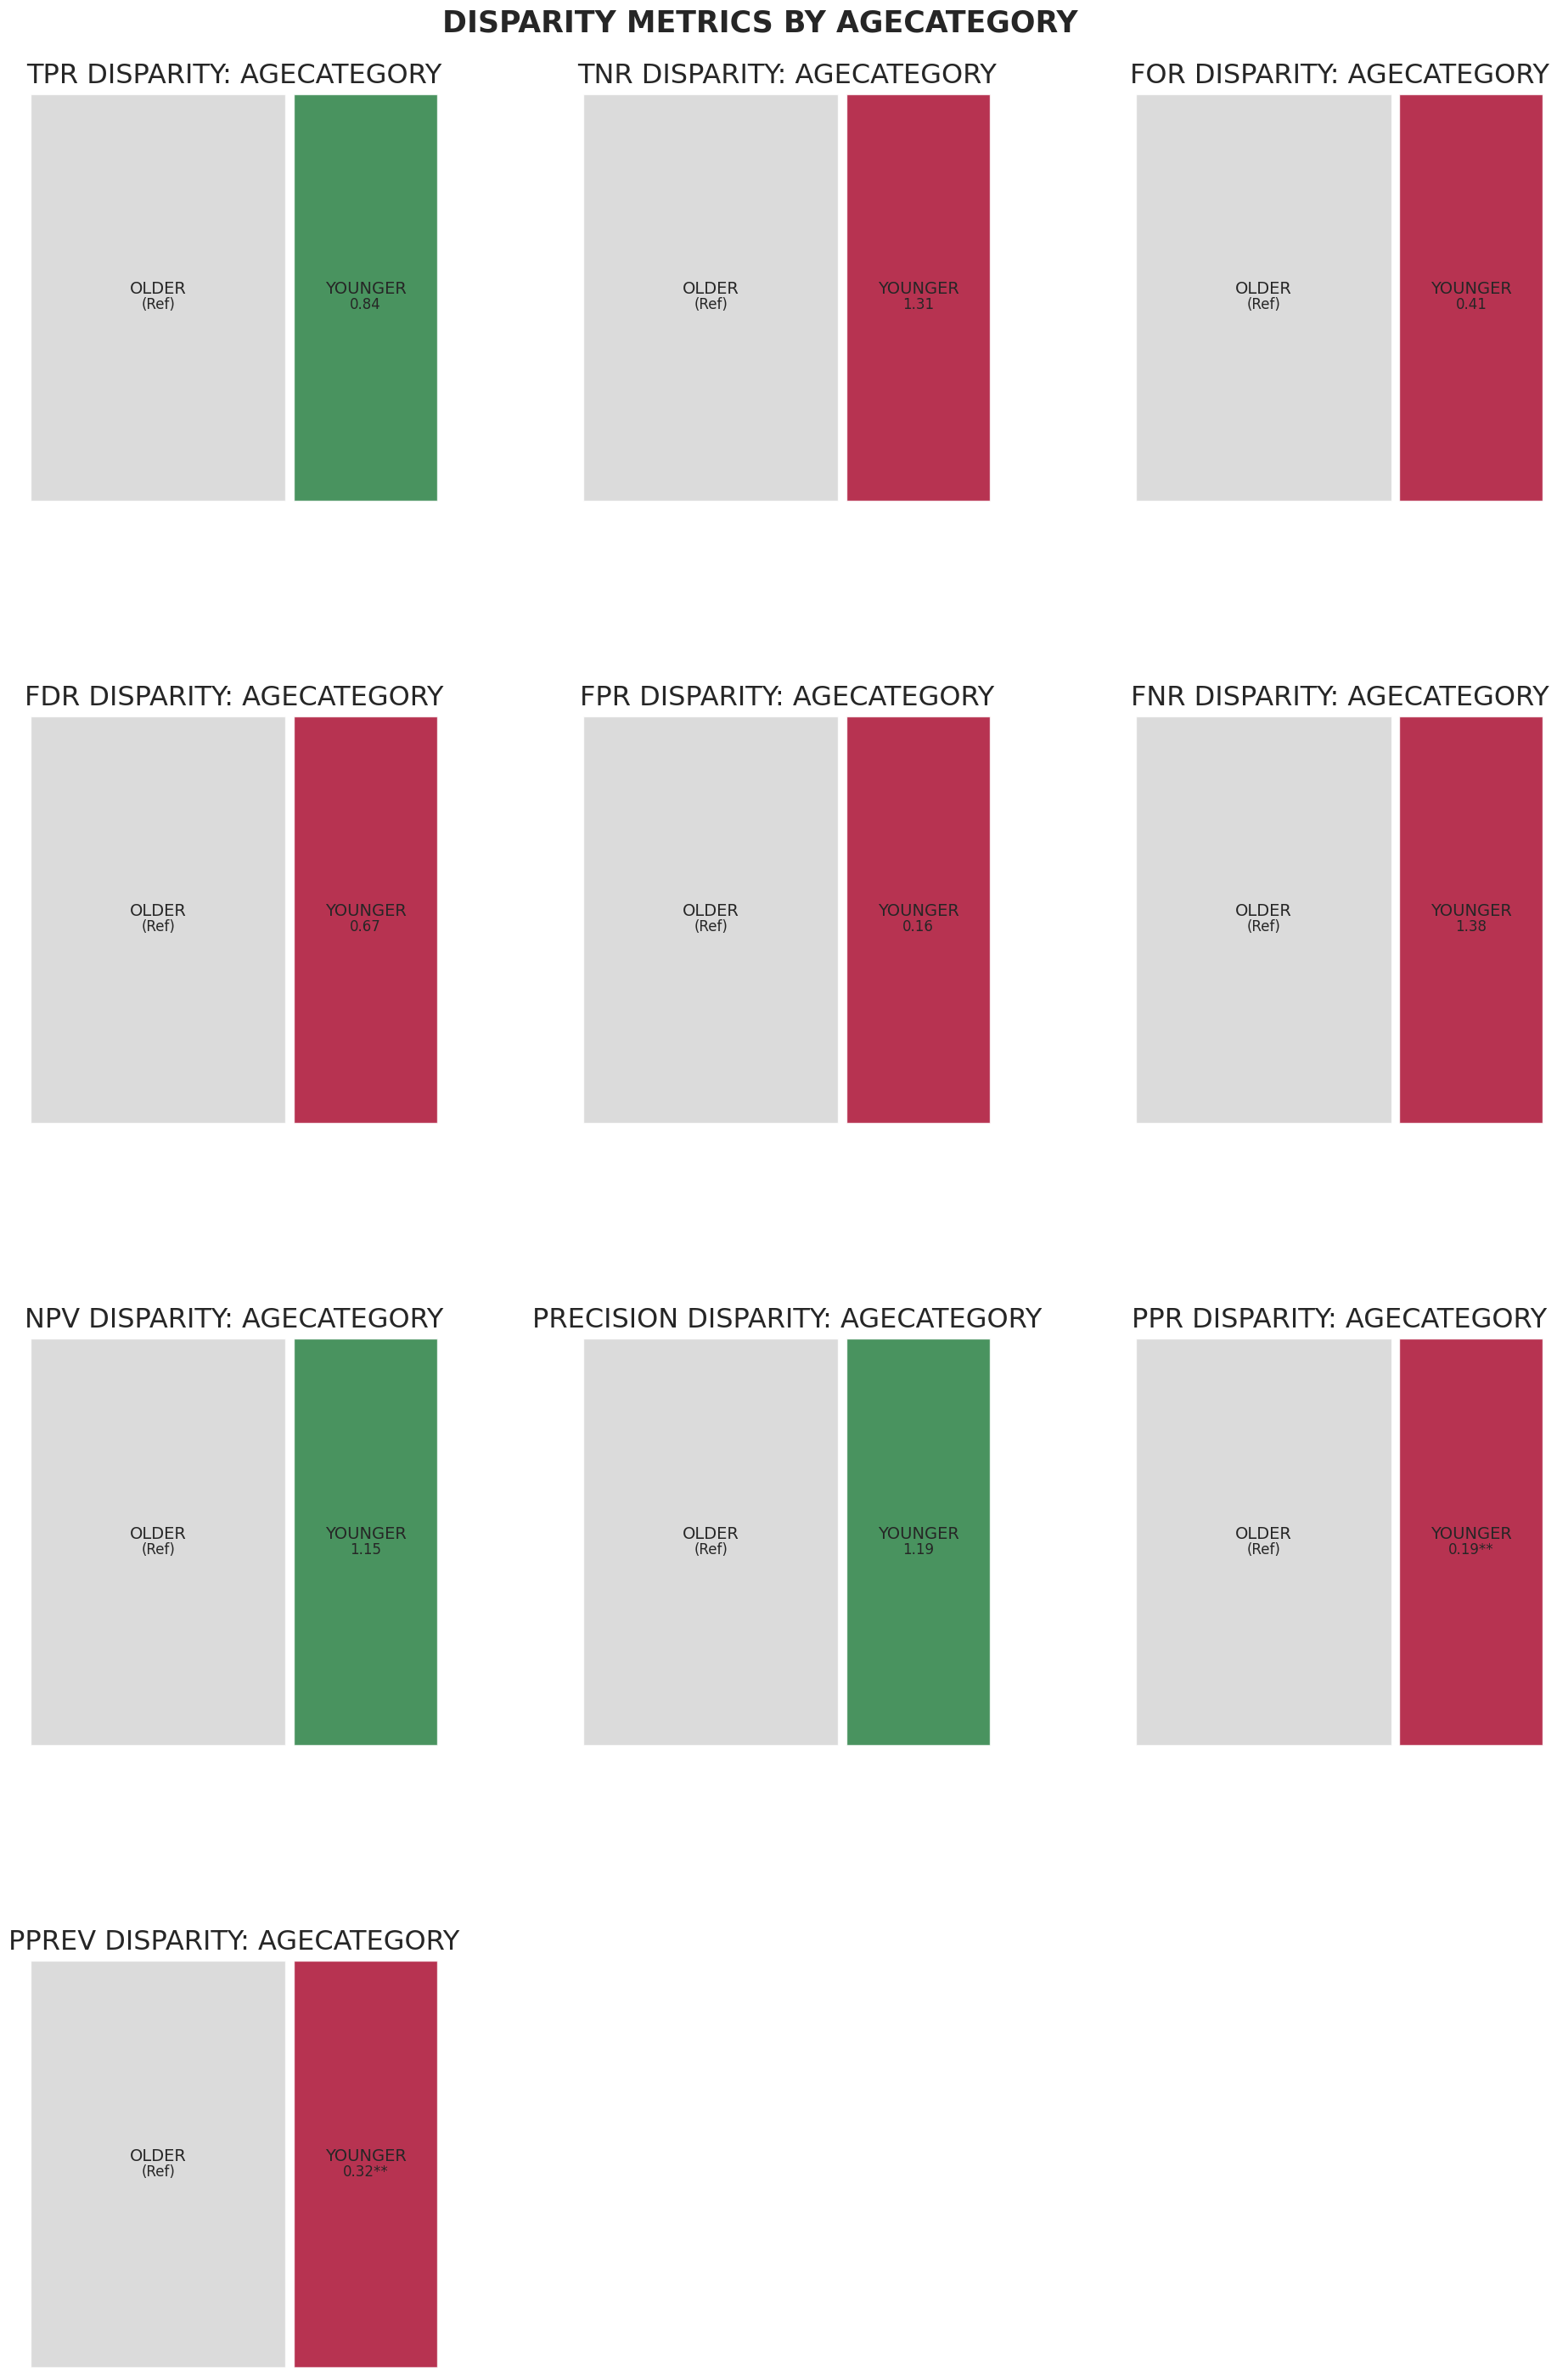

In [91]:
s_all_f = aqp.plot_fairness_disparity_all(fdf, attributes=[sensitive_attribute], metrics='all', significance_alpha=0.05, label_dict=dictionary)

Visualizing parity between groups in the sensitive attribute for the interesting disparity metric:

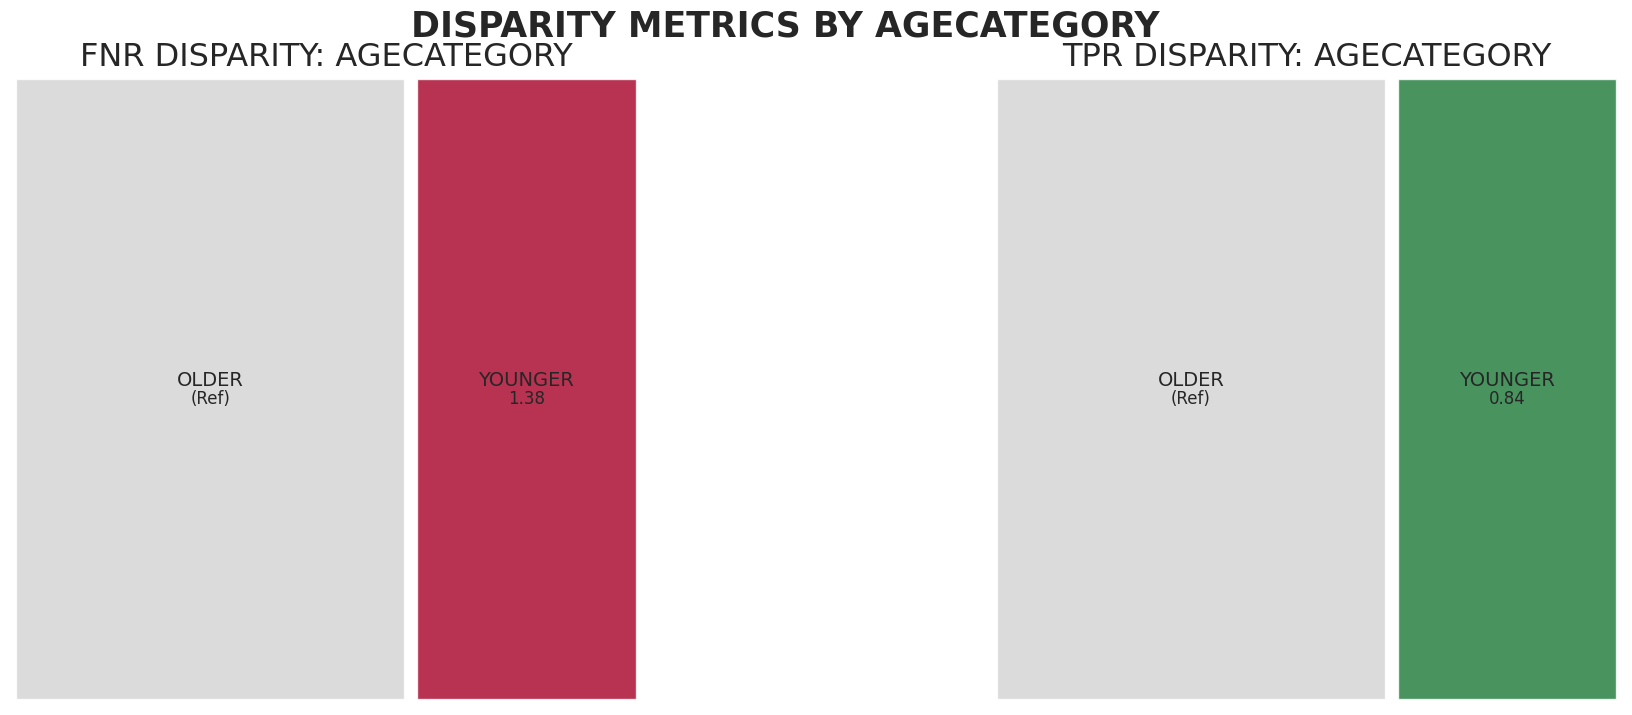

In [92]:
s_fnr_tpr_f = aqp.plot_fairness_disparity_all(fdf, attributes=[sensitive_attribute], metrics=[metrics[0], metrics[1]], label_dict=dictionary)

The treemap above displays **FNR** and **TPR** disparity values between *AgeCategory* attribute groups calculated based on a predefined reference group (**OLDER**).

We see very quickly that **YOUNGER** group has:
*   a <font color=red>‘False’</font>  parity determination for the **FNR**
*   a <font color=green>‘True’</font> parity determination for the **TPR**.

#### <font color=#FA786D>Conclusions</font> 

Disparity comparison of *AgeCategory* for interesting measures using **OLDER** (1) group as reference

Disparities of metrics are here presented first in absolute values and then as proportions:

In [93]:
ap.absolute(bdf, metrics, sensitive_attribute, fairness_threshold = disparity_tolerance)

/usr/local/lib/python3.9/dist-packages/altair/utils/core.py:283: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



alt.LayerChart(...)

In [94]:
ap.disparity(bdf, metrics, sensitive_attribute, fairness_threshold = disparity_tolerance)

/usr/local/lib/python3.9/dist-packages/altair/utils/core.py:283: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



alt.LayerChart(...)

It is clear from the graph that the False Negative Rate (**FNR**) of the **YOUNGER** group exceed the disparity tolerance treshold, highlighting an unfairness in our model.

On the contrary the True Positive Rate (**TPR**) shows that the **YOUNGER** group does not exceed the disparity tolerance treshold, revealing that the predictive model is unbiased over this measure.

---

Summarizing all the results obtained:

In [95]:
ap.summary(bdf, metrics, sensitive_attribute, fairness_threshold = disparity_tolerance)

/usr/local/lib/python3.9/dist-packages/altair/utils/core.py:283: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



alt.VConcatChart(...)

As seen before for the *AgeCategory* we finally state:

*   The False Negative Rate (**FNR**) of the **YOUNGER** group did not pass the parity test because:
> The **YOUNGER** group presents an **FNR disparity** equal to 1.38 with respect to the reference group that is above the treshold.

*   The True Positive Rate (**TPR**) passes the parity test because:
> The **YOUNGER** group presents an **FNR disparity** equal to 1.18 with respect to the reference group that is below the treshold.

Our model is then biased for the *AgeCategory* attribute for the False Negative Rate (**FNR**), whilst it isn't for the True Positive Rate (**TPR**).

---

**Basically the model tends to indicate that people actually with diabetes are more likely to be labeled negative at a younger age, this is the *bias* of our model.**

# <font color=#EF9A7D>Bibliography</font>


<font color=#E5FCA8>Dataset:</font>
* https://www.kaggle.com/datasets/mathchi/diabetes-data-set
* https://www.openml.org/search?type=data&status=active&id=43903&sort=runs

<font color=#E5FCA8>Random Forest Classifier:</font>
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

<font color=#E5FCA8>Aequitas Toolkit:</font>
* https://dssg.github.io/aequitas/
* https://arxiv.org/pdf/1811.05577v2.pdf
* https://textbook.coleridgeinitiative.org/chap-bias.html#sec:applications
* http://www.datasciencepublicpolicy.org/our-work/tools-guides/aequitas/
* https://dssg.github.io/fairness_tutorial/notebooks/
* https://www.labelia.org/en/blog/fairness-in-machine-learning
* https://morioh.com/p/3ff7a77de9e4
* https://cscherrer.github.io/post/confusion-confusion/

<font color=#E5FCA8>Tools used:</font>
* https://pypi.org/
* https://github.com/
* Aequitas toolkit

<font color=#E5FCA8>Other useful sources:</font>
* https://packaging.python.org/en/latest/tutorials/packaging-projects/
* https://pandas.pydata.org/docs/reference/frame.html
* https://stackoverflow.com/
* https://miniwebtool.com/it/hex-calculator/
* https://www.plus2net.com/python/tkinter-colors.php